## Import standard dependencies

In [2]:
import numpy as np
import pandas as pd
from scipy import stats
from numpy import random as rd
import os
import json
from sklearn.decomposition import PCA
import multiprocessing, multiprocessing.pool
import matplotlib.pyplot as plt
import seaborn as sns
import time
from collections import Counter
from sklearn.manifold import TSNE
import pickle
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn import metrics
from sklearn import tree
import miner_20190520 as miner
%matplotlib inline
plt.style.use('ggplot')

## Import XGBoost

In [5]:
# XGBoost predictor imports
os.environ['KMP_DUPLICATE_LIB_OK']='True' #prevents kernel from dying when running XGBClassifier
from xgboost import XGBClassifier

## Create directory to save output files

In [3]:
# create name for results folder where output files will be saved
resultsFolder = "results_minCorrelation_0o2_50"

# create results directory
resultsDirectory = os.path.join(os.path.split(os.getcwd())[0],resultsFolder)
if not os.path.isdir(resultsDirectory):
    os.mkdir(resultsDirectory)

## Load primary data

In [4]:
#If previous results exist, use miner.read_json to load them
revisedClusters = miner.read_json(os.path.join(resultsDirectory,"coexpressionDictionary.json"))
coexpressionModules = miner.read_json(os.path.join(resultsDirectory,"coexpressionModules.json"))
regulonModules = miner.read_json(os.path.join(resultsDirectory,"regulons.json"))
mechanisticOutput = miner.read_json(os.path.join(resultsDirectory,"mechanisticOutput.json"))
regulonDf = pd.read_csv(os.path.join(resultsDirectory,"regulonDf.csv"),index_col=0,header=0)
coherent_samples_matrix = pd.read_csv(os.path.join(resultsDirectory,"coherentMembers.csv"),index_col=0,header=0)
overExpressedMembersMatrix = pd.read_csv(os.path.join(resultsDirectory,"overExpressedMembers.csv"),index_col=0,header=0)
underExpressedMembersMatrix = pd.read_csv(os.path.join(resultsDirectory,"underExpressedMembers.csv"),index_col=0,header=0)

## Load and map test data

In [6]:
# define modules to interrogate in test sets
reference_modules = regulonModules

# GSE24080UAMS - test set 1
expressionDataGSE24080UAMS = pd.read_csv(os.path.join(os.path.split(os.getcwd())[0],"data","expression_myeloma_20190531","GSE24080UAMSentrezIDlevel.csv"),index_col=0,header=0)
expressionDataGSE24080UAMS, _ = miner.identifierConversion(expressionData=expressionDataGSE24080UAMS)
expressionDataGSE24080UAMS = miner.zscore(expressionDataGSE24080UAMS)
bkgdGSE24080UAMS = miner.backgroundDf(expressionDataGSE24080UAMS)
overExpressedMembersGSE24080UAMS = miner.biclusterMembershipDictionary(reference_modules,bkgdGSE24080UAMS,label=2,p=0.1)
overExpressedMembersMatrixGSE24080UAMS = miner.membershipToIncidence(overExpressedMembersGSE24080UAMS,expressionDataGSE24080UAMS)
underExpressedMembersGSE24080UAMS = miner.biclusterMembershipDictionary(reference_modules,bkgdGSE24080UAMS,label=0,p=0.1)
underExpressedMembersMatrixGSE24080UAMS = miner.membershipToIncidence(underExpressedMembersGSE24080UAMS,expressionDataGSE24080UAMS)

# GSE19784HOVON65 - test set 2
expressionDataGSE19784HOVON65 = pd.read_csv(os.path.join(os.path.split(os.getcwd())[0],"data","expression_myeloma_20190531","GSE19784HOVON65entrezIDlevel.csv"),index_col=0,header=0)
expressionDataGSE19784HOVON65, _ = miner.identifierConversion(expressionData=expressionDataGSE19784HOVON65)
expressionDataGSE19784HOVON65 = miner.zscore(expressionDataGSE19784HOVON65)
bkgdGSE19784HOVON65 = miner.backgroundDf(expressionDataGSE19784HOVON65)
overExpressedMembersGSE19784HOVON65 = miner.biclusterMembershipDictionary(reference_modules,bkgdGSE19784HOVON65,label=2,p=0.1)
overExpressedMembersMatrixGSE19784HOVON65 = miner.membershipToIncidence(overExpressedMembersGSE19784HOVON65,expressionDataGSE19784HOVON65)
underExpressedMembersGSE19784HOVON65 = miner.biclusterMembershipDictionary(reference_modules,bkgdGSE19784HOVON65,label=0,p=0.1)
underExpressedMembersMatrixGSE19784HOVON65 = miner.membershipToIncidence(underExpressedMembersGSE19784HOVON65,expressionDataGSE19784HOVON65)

# EMTAB4032 - test set 3
expressionDataEMTAB4032 = pd.read_csv(os.path.join(os.path.split(os.getcwd())[0],"data","expression_myeloma_20190531","EMTAB4032entrezIDlevel.csv"),index_col=0,header=0)
expressionDataEMTAB4032, _ = miner.identifierConversion(expressionData=expressionDataEMTAB4032)
expressionDataEMTAB4032 = miner.zscore(expressionDataEMTAB4032)
bkgdEMTAB4032 = miner.backgroundDf(expressionDataEMTAB4032)
overExpressedMembersEMTAB4032 = miner.biclusterMembershipDictionary(reference_modules,bkgdEMTAB4032,label=2,p=0.1)
overExpressedMembersMatrixEMTAB4032 = miner.membershipToIncidence(overExpressedMembersEMTAB4032,expressionDataEMTAB4032)
underExpressedMembersEMTAB4032 = miner.biclusterMembershipDictionary(reference_modules,bkgdEMTAB4032,label=0,p=0.1)
underExpressedMembersMatrixEMTAB4032 = miner.membershipToIncidence(underExpressedMembersEMTAB4032,expressionDataEMTAB4032)

# generate discrete network mapping matrices for each dataset
dfr = overExpressedMembersMatrix-underExpressedMembersMatrix
dfrGSE24080UAMS = overExpressedMembersMatrixGSE24080UAMS-underExpressedMembersMatrixGSE24080UAMS
dfrGSE19784HOVON65 = overExpressedMembersMatrixGSE19784HOVON65-underExpressedMembersMatrixGSE19784HOVON65
dfrEMTAB4032 = overExpressedMembersMatrixEMTAB4032-underExpressedMembersMatrixEMTAB4032

completed identifier conversion.
16998 genes were converted.
completed z-transformation.
done!
done!
completed identifier conversion.
16998 genes were converted.
completed z-transformation.
done!
done!
completed identifier conversion.
17228 genes were converted.
completed z-transformation.
done!
done!


## Load primary survival data

In [10]:
# load primary survival data (i.e., corresponding to expression data training set)
survivalMMRF = pd.read_csv(os.path.join(os.path.split(os.getcwd())[0],"data","survival_myeloma_20190531","survivalMMRFIA12.csv"),index_col=0,header=0)
survivalDfMMRF = survivalMMRF.iloc[:,0:2]
survivalDfMMRF.columns = ["duration","observed"]
overExpressedMembersMatrixMMRF = overExpressedMembersMatrix
kmDfMMRF = miner.kmAnalysis(survivalDf=survivalDfMMRF,durationCol="duration",statusCol="observed")
guanSurvivalDfMMRF= miner.guanRank(kmSurvival=kmDfMMRF)

## Load test survival data

In [7]:
survival = pd.read_csv(os.path.join(os.path.split(os.getcwd())[0],"data","survival_myeloma_20190531","globalClinTraining.csv"),index_col=0,header=0)

# GSE24080UAMS
survivalGSE24080UAMS = survival[survival.index=='GSE24080UAMS']
survivalGSE24080UAMS.index = survivalGSE24080UAMS.iloc[:,0]
survivalDfGSE24080UAMS = survivalGSE24080UAMS.loc[:,["D_PFS","D_PFS_FLAG"]]
survivalDfGSE24080UAMS.columns = ["duration","observed"]
kmDfGSE24080UAMS = miner.kmAnalysis(survivalDf=survivalDfGSE24080UAMS,durationCol="duration",statusCol="observed")
guanSurvivalDfGSE24080UAMS = miner.guanRank(kmSurvival=kmDfGSE24080UAMS)

# GSE19784HOVON65 
survivalGSE19784HOVON65 = survival[survival.index=='HOVON65']
survivalGSE19784HOVON65.index = survivalGSE19784HOVON65.iloc[:,0]
survivalDfGSE19784HOVON65 = survivalGSE19784HOVON65.loc[:,["D_PFS","D_PFS_FLAG"]]
survivalDfGSE19784HOVON65.columns = ["duration","observed"]
kmDfGSE19784HOVON65 = miner.kmAnalysis(survivalDf=survivalDfGSE19784HOVON65,durationCol="duration",statusCol="observed")
guanSurvivalDfGSE19784HOVON65 = miner.guanRank(kmSurvival=kmDfGSE19784HOVON65)

# EMTAB4032
survivalEMTAB4032 = survival[survival.index=='EMTAB4032']
survivalEMTAB4032.index = survivalEMTAB4032.iloc[:,0]
survivalDfEMTAB4032 = survivalEMTAB4032.loc[:,["D_PFS","D_PFS_FLAG"]]
survivalDfEMTAB4032.columns = ["duration","observed"]
kmDfEMTAB4032 = miner.kmAnalysis(survivalDf=survivalDfEMTAB4032,durationCol="duration",statusCol="observed")
guanSurvivalDfEMTAB4032 = miner.guanRank(kmSurvival=kmDfEMTAB4032)

# Generate predictors

## 1. Decision tree predictors

### 1a. Cross-dataset prediction

(11, 0.6030065183656668, 3.4161895789516423)
classified 18.8 percent of training population as high-risk
classified 19.8 percent of test population as high-risk
classified 22.0 percent of training population as high-risk
classified 18.5 percent of test population as high-risk
classified 18.6 percent of training population as high-risk
classified 28.9 percent of test population as high-risk
classified 19.6 percent of training population as high-risk
classified 20.0 percent of test population as high-risk
11


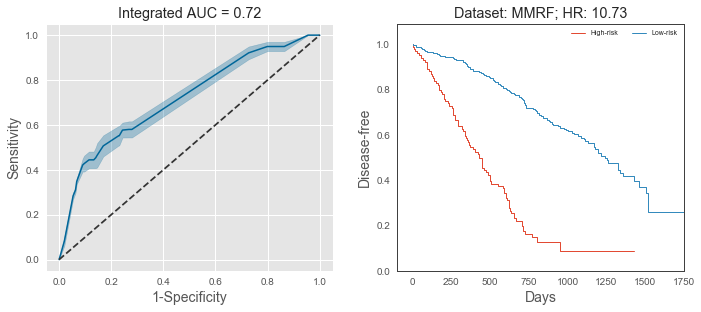

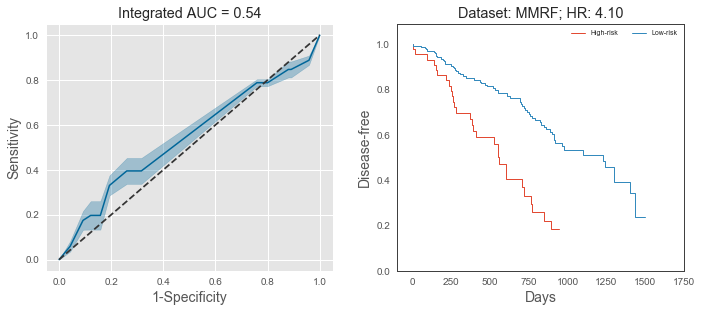

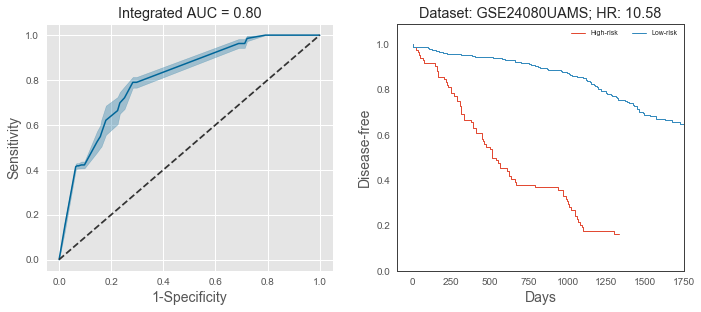

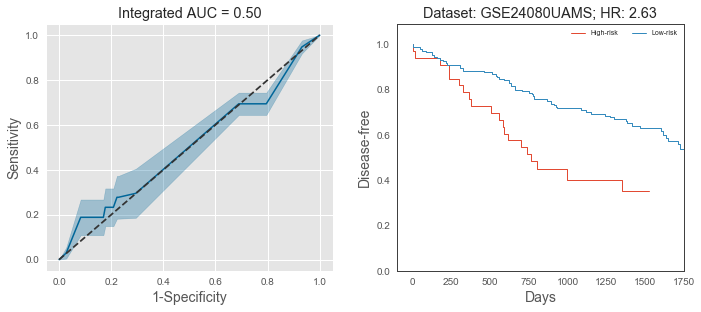

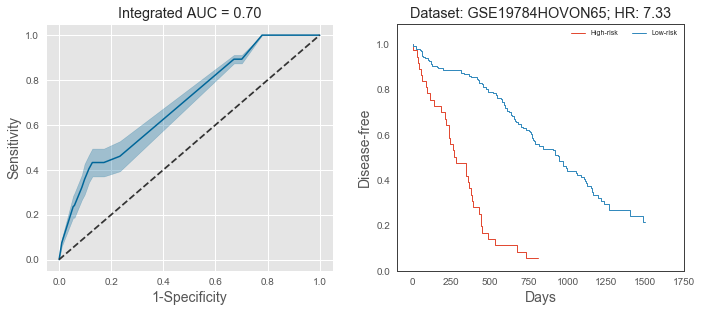

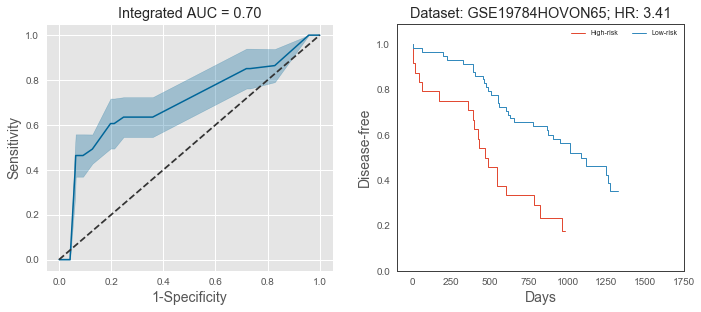

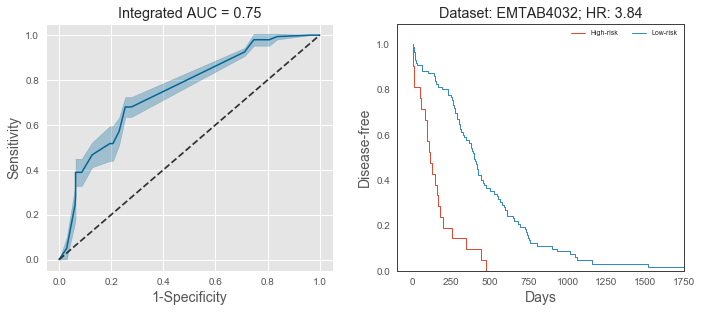

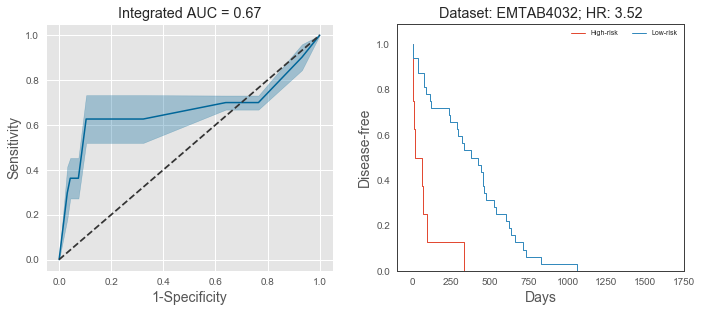

In [492]:
reload(miner)

membership_datasets = [
    overExpressedMembersMatrix,
    overExpressedMembersMatrixGSE24080UAMS,
    overExpressedMembersMatrixGSE19784HOVON65,
    overExpressedMembersMatrixEMTAB4032
]

survival_datasets = [
    guanSurvivalDfMMRF,
    guanSurvivalDfGSE24080UAMS,
    guanSurvivalDfGSE19784HOVON65,
    guanSurvivalDfEMTAB4032
]

dataset_labels = [
    "MMRF",
    "GSE24080UAMS",
    "GSE19784HOVON65",
    "EMTAB4032"
]

classifier, class0, class1, mean_aucs, mean_hrs, pct_labeled, precision_matrix, recall_matrix = miner.generatePredictor(membership_datasets,survival_datasets,dataset_labels,iterations = 30,method='decisionTree',output_directory=resultsDirectory,metric='hazard_ratio',separate_results=True,class1_proportion=0.30,test_proportion=0.30,best_state=11,test_only=True)

(0.0, 1.0)

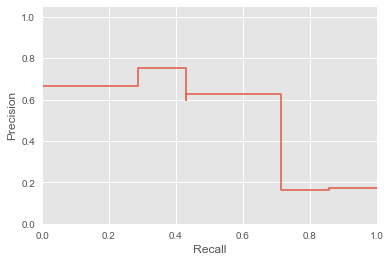

In [520]:

recall = recall_matrix[2]
precision = precision_matrix[2]
plt.step(recall, precision, alpha=0.8,where='post')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])

In [511]:
precision

array([0.175     , 0.16216216, 0.16216216, 0.16666667, 0.16666667,
       0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
       0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.17857143,
       0.17857143, 0.19230769, 0.19230769, 0.19230769, 0.19230769,
       0.19230769, 0.33333333, 0.33333333, 0.33333333, 0.35714286,
       0.35714286, 0.38461538, 0.38461538, 0.38461538, 0.38461538,
       0.38461538, 0.38461538, 0.38461538, 0.38461538, 0.5       ,
       0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
       0.5       , 0.5       , 0.5       , 0.625     , 0.625     ,
       0.625     , 0.625     , 0.625     , 0.625     , 0.625     ,
       0.625     , 0.625     , 0.625     , 0.625     , 0.6       ,
       0.6       , 0.6       , 0.6       , 0.6       , 0.75      ,
       0.75      , 0.75      , 0.75      , 0.75      , 0.75      ,
       0.75      , 0.75      , 0.75      , 0.75      , 0.75      ,
       0.75      , 0.75      , 0.75      , 0.75      , 0.75   

### Evaluate classifications in each separate dataset

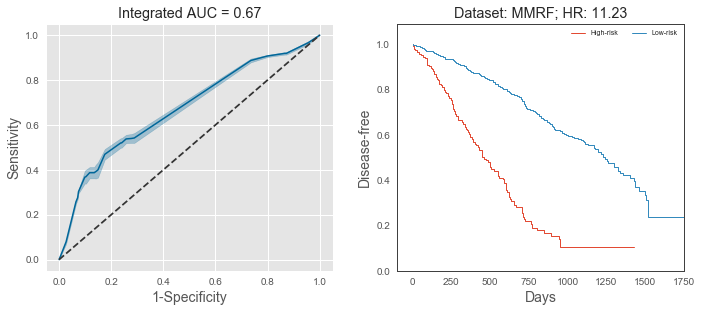

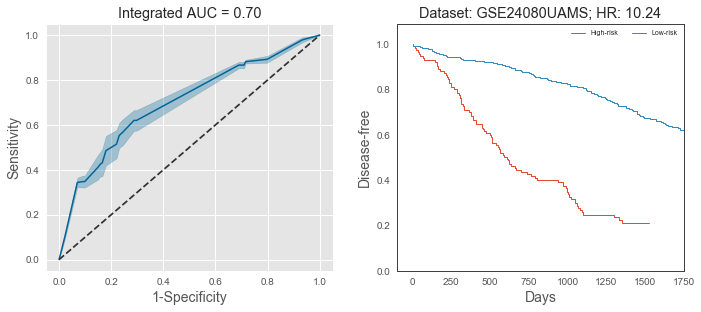

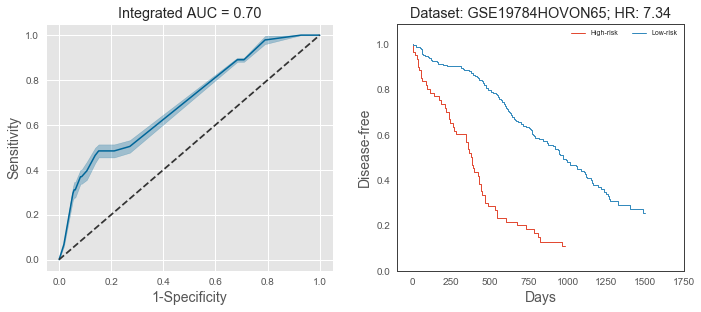

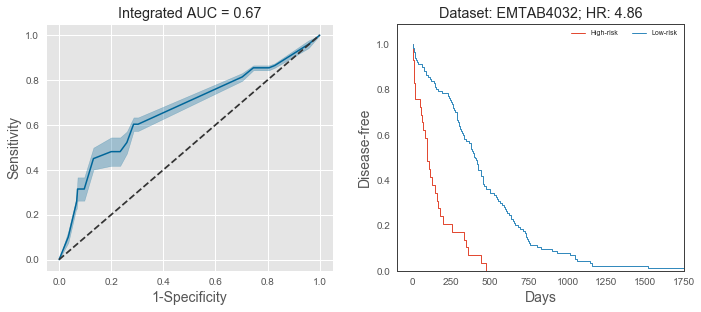

In [470]:
membership_datasets = [
    overExpressedMembersMatrix,
    overExpressedMembersMatrixGSE24080UAMS,
    overExpressedMembersMatrixGSE19784HOVON65,
    overExpressedMembersMatrixEMTAB4032
]

survival_datasets = [
    guanSurvivalDfMMRF,
    guanSurvivalDfGSE24080UAMS,
    guanSurvivalDfGSE19784HOVON65,
    guanSurvivalDfEMTAB4032
]

dataset_labels = [
    "MMRF",
    "GSE24080UAMS",
    "GSE19784HOVON65",
    "EMTAB4032"
]

predictions = []
for p in range(len(membership_datasets)):
    tmp_predictions = classifier.predict(np.array(membership_datasets[p].T))
    predictions.append(tmp_predictions)

for j in range(len(membership_datasets)):
    mtrx = membership_datasets[j]
    guan_srv = survival_datasets[j]
    survival_tag = dataset_labels[j]
    lbls = predictions[j]
    aucs, cutoffs, tpr_list, fpr_list, hazard_ratio = miner.riskStratification(lbls,mtrx,guan_srv,survival_tag,classifier,guan_rank=False,resultsDirectory=None,plot_all=False,plot_any=True)


## Determine percent predicted high-risk

In [471]:
# generate predictions for each dataset
reload(miner)
predictor_tag = "IA12"
mmrfIA12_predictions = classifier.predict(np.array(overExpressedMembersMatrix.T))
GSE24080UAMS_predictions = classifier.predict(np.array(overExpressedMembersMatrixGSE24080UAMS.T))
GSE19784HOVON65_predictions = classifier.predict(np.array(overExpressedMembersMatrixGSE19784HOVON65.T))
EMTAB4032_predictions = classifier.predict(np.array(overExpressedMembersMatrixEMTAB4032.T))

percent_classified_hr = 100*sum(mmrfIA12_predictions)/float(len(mmrfIA12_predictions))
print('classified {:.1f} percent of population as high-risk'.format(percent_classified_hr))
percent_classified_hr = 100*sum(GSE24080UAMS_predictions)/float(len(GSE24080UAMS_predictions))
print('classified {:.1f} percent of population as high-risk'.format(percent_classified_hr))
percent_classified_hr = 100*sum(GSE19784HOVON65_predictions)/float(len(GSE19784HOVON65_predictions))
print('classified {:.1f} percent of population as high-risk'.format(percent_classified_hr))
percent_classified_hr = 100*sum(EMTAB4032_predictions)/float(len(EMTAB4032_predictions))
print('classified {:.1f} percent of population as high-risk'.format(percent_classified_hr))

classified 22.0 percent of population as high-risk
classified 20.9 percent of population as high-risk
classified 21.6 percent of population as high-risk
classified 19.7 percent of population as high-risk


### Visualize decision-tree

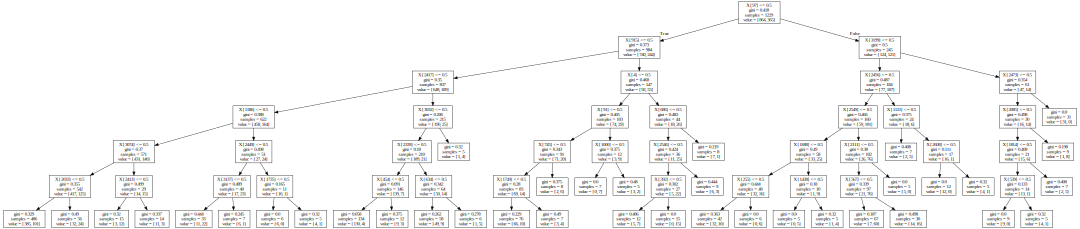

In [472]:
from sklearn import tree
from sklearn.externals.six import StringIO  
import pydot 
from graphviz import Source

dot_data = StringIO() 
tree.export_graphviz(classifier, out_file=dot_data) 
graph = pydot.graph_from_dot_data(dot_data.getvalue()) 
#graph[0].write_pdf(os.path.join(resultsDirectory,"decisionTreeAUC.pdf"))

# visualize decision tree
graph[0].set_graph_defaults(size = "\"15,15\"")
decisionTree = Source(graph[0].to_string())
decisionTree

### Save predictor

In [282]:
# save the model to disk
filename = os.path.join(resultsDirectory,'miner_xgboost_alldata_predictor.pkl')
pickle.dump(classifier, open(filename, 'wb'))

# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))


## Investigate feature importance

### Quantify importance of each predictive feature

In [480]:
# Quantify importance of individual features
rank = 1 # 1 is the most important feature, -1 is the least important non-zero feature
fi = np.array(classifier.feature_importances_)
feature = overExpressedMembersMatrix.index[np.argsort(fi)[-rank]]
print(feature,fi[np.argsort(fi)[-rank]])

(97, 0.1819752953380759)


### Tabulate feature importances into dataframe

In [481]:
# Tabulate important features into dataframe
fi_df = pd.DataFrame(fi)
fi_df.index = overExpressedMembersMatrix.index
fi_df.columns = ["feature_importance"]
fi_df_filtered = fi_df[fi_df["feature_importance"]>0]
fi_df_filtered.index

Int64Index([  70,   97,  161,  270,  314,  540,  633,  649,  800,  803,  915,
             946, 1083, 1212, 1302, 1311, 1391, 1397, 1432, 1459, 1546, 1568,
            1570, 1618, 1880, 1930, 2171, 2183, 2354, 2549, 2712, 2774, 2791,
            2812, 2920, 3168, 3193],
           dtype='int64')

### List number of times individual genes and regulators appear in important features


In [482]:
regulonDf_indexed = regulonDf.copy()
regulonDf_indexed.index = list(regulonDf.Regulon_ID)

allgenes = []
allregulators = []
for reg_id in list(fi_df_filtered.index):
    genes = list(regulonDf_indexed.loc[reg_id,"Gene"])
    regulator = list(regulonDf_indexed.loc[reg_id,"Regulator"])[0]
    allgenes.append(genes)
    allregulators.append(regulator)
    
count_genes = Counter(np.hstack(allgenes))
count_regulators = Counter(allregulators)

genes_mc = count_genes.most_common()
regulators_mc = count_regulators.most_common()
print(genes_mc[0:30],regulators_mc[0:30])

([('ENSG00000185658', 2), ('ENSG00000158296', 2), ('ENSG00000123643', 2), ('ENSG00000198855', 2), ('ENSG00000125347', 2), ('ENSG00000072364', 2), ('ENSG00000141682', 2), ('ENSG00000139163', 2), ('ENSG00000185753', 2), ('ENSG00000157303', 2), ('ENSG00000139278', 2), ('ENSG00000167657', 2), ('ENSG00000119917', 2), ('ENSG00000164151', 2), ('ENSG00000197415', 2), ('ENSG00000144840', 2), ('ENSG00000020633', 2), ('ENSG00000004897', 2), ('ENSG00000001630', 2), ('ENSG00000001084', 2), ('ENSG00000155363', 2), ('ENSG00000128335', 2), ('ENSG00000120159', 2), ('ENSG00000132357', 2), ('ENSG00000170571', 2), ('ENSG00000082512', 2), ('ENSG00000213625', 2), ('ENSG00000145725', 2), ('ENSG00000169122', 2), ('ENSG00000105778', 2)], [('ENSG00000281306', 2), ('ENSG00000168269', 2), ('ENSG00000005889', 1), ('ENSG00000164916', 1), ('ENSG00000185591', 1), ('ENSG00000128645', 1), ('ENSG00000175832', 1), ('ENSG00000221869', 1), ('ENSG00000276561', 1), ('ENSG00000118260', 1), ('ENSG00000182944', 1), ('ENSG000000

### Convert gene identifiers to gene symbols for reference

In [484]:
# requires installation of "mygene"

number_of_results = 30 #number of genes/regulators to convert
conv_ = [i[0] for i in genes_mc[0:number_of_results]]
conv_ = [i[0] for i in regulators_mc[0:number_of_results]]

geneset = miner.gene_conversion(conv_,list_symbols=True)
np.savetxt(os.path.join(resultsDirectory,"geneset.txt"),geneset,fmt="%1.50s")
print(geneset)

querying 1-30...done.
Finished.
[u'ZNF35', u'FOXI1', u'ZFX', u'FOXK1', u'SP1', u'HOXD1', u'ETV4', u'CEBPD', u'IRF7', u'CREB1', u'EWSR1', u'PAX6', u'PKNOX1', u'IRF5', u'MAFK', u'BHLHE40', u'E2F4', u'SOX4', u'POU2F1', u'ELK1', u'ZBTB12', u'NR2C2', u'FOXO1', u'FOXJ2', u'FOXO3', u'HSF2', u'NR3C1', u'BCL6', u'MSX1', u'MEF2A']


### 1b. Individual dataset prediction

(2, 0.7328152880105996, 3.3034156834802553)
classified 17.3 percent of training population as high-risk
classified 14.7 percent of test population as high-risk
2


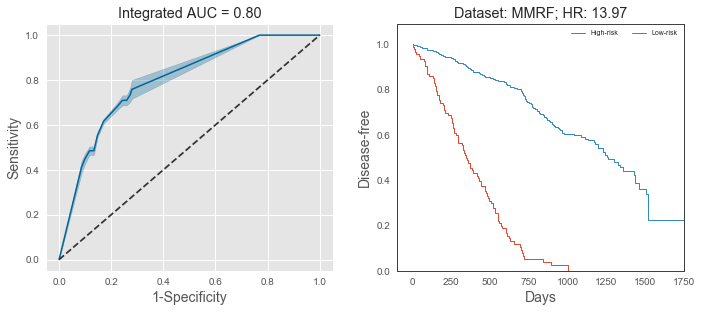

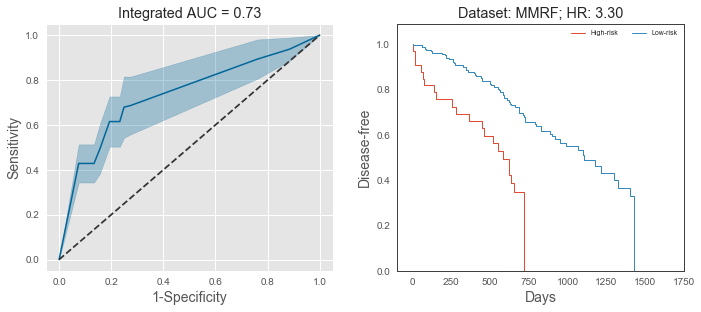

In [437]:
reload(miner)

membership_datasets = [
    overExpressedMembersMatrix,
]

survival_datasets = [
    guanSurvivalDfMMRF,
]

dataset_labels = [
    "MMRF",
]

classifier, class0, class1, mean_aucs, mean_hrs, pct_labeled = miner.generatePredictor(membership_datasets,survival_datasets,dataset_labels,iterations = 30,method='decisionTree',output_directory=resultsDirectory,metric='hazard_ratio',separate_results=True,class1_proportion=0.30,test_proportion=0.30,best_state=2)

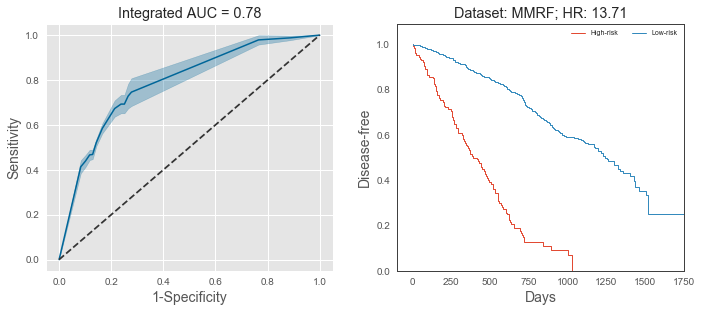

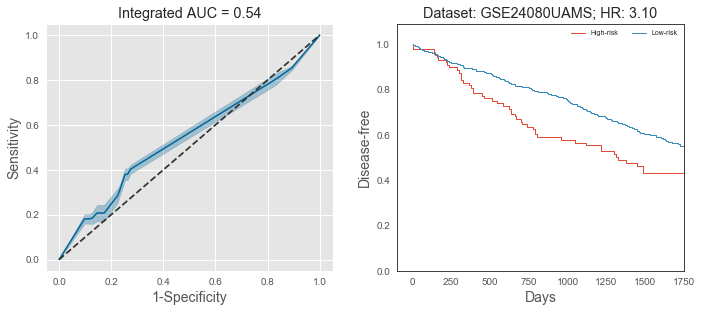

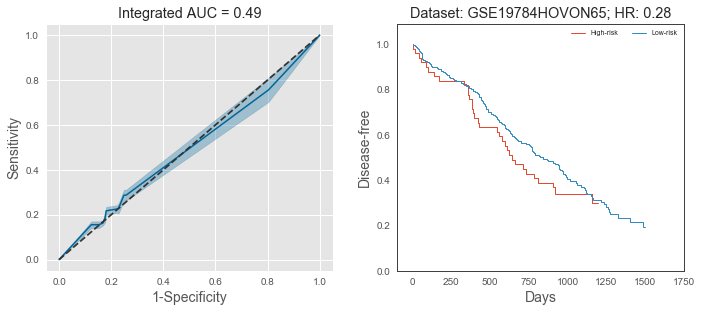

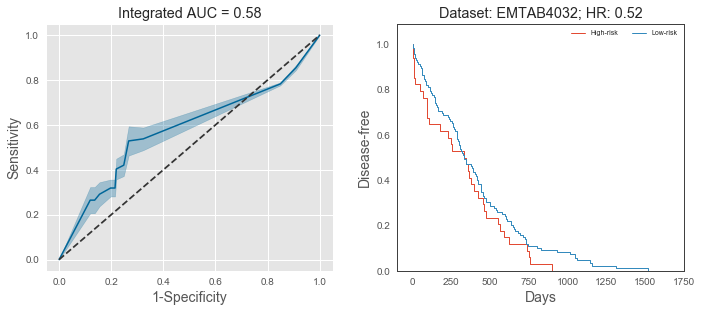

In [438]:
membership_datasets = [
    overExpressedMembersMatrix,
    overExpressedMembersMatrixGSE24080UAMS,
    overExpressedMembersMatrixGSE19784HOVON65,
    overExpressedMembersMatrixEMTAB4032
]

survival_datasets = [
    guanSurvivalDfMMRF,
    guanSurvivalDfGSE24080UAMS,
    guanSurvivalDfGSE19784HOVON65,
    guanSurvivalDfEMTAB4032
]

dataset_labels = [
    "MMRF",
    "GSE24080UAMS",
    "GSE19784HOVON65",
    "EMTAB4032"
]

predictions = []
for p in range(len(membership_datasets)):
    tmp_predictions = classifier.predict(np.array(membership_datasets[p].T))
    predictions.append(tmp_predictions)

for j in range(len(membership_datasets)):
    mtrx = membership_datasets[j]
    guan_srv = survival_datasets[j]
    survival_tag = dataset_labels[j]
    lbls = predictions[j]
    aucs, cutoffs, tpr_list, fpr_list, hazard_ratio = miner.riskStratification(lbls,mtrx,guan_srv,survival_tag,classifier,guan_rank=False,resultsDirectory=None,plot_all=False,plot_any=True)


### Visualize decision-tree

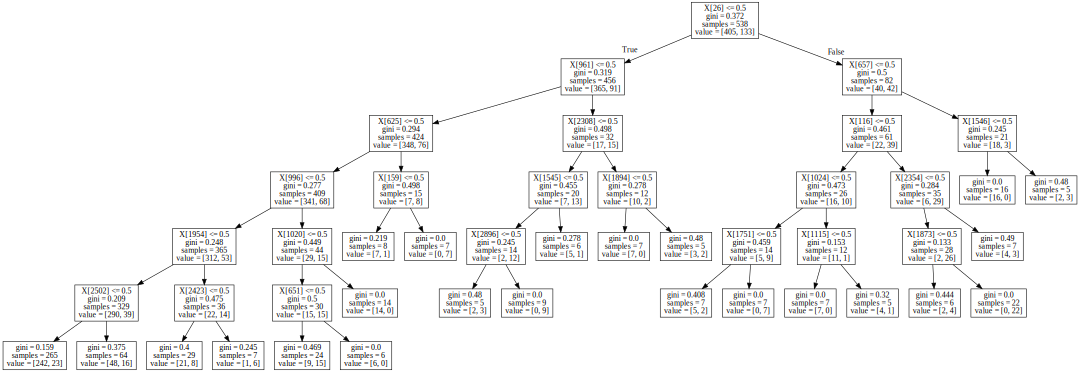

In [44]:
from sklearn import tree
from sklearn.externals.six import StringIO  
import pydot 
from graphviz import Source

dot_data = StringIO() 
tree.export_graphviz(classifier, out_file=dot_data) 
graph = pydot.graph_from_dot_data(dot_data.getvalue()) 
#graph[0].write_pdf(os.path.join(resultsDirectory,"decisionTreeAUC.pdf"))

# visualize decision tree
graph[0].set_graph_defaults(size = "\"15,15\"")
decisionTree = Source(graph[0].to_string())
decisionTree

### Save predictor

In [31]:
# save the model to disk
filename = os.path.join(resultsDirectory,'miner_decisionTree_predictor.pkl')
pickle.dump(classifier, open(filename, 'wb'))

# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))


## 2. XGBoost predictors

### 2a. Cross-dataset prediction

(11, 0.6817566985473916, 4.4205625095556345)
classified 11.3 percent of training population as high-risk
classified 8.8 percent of test population as high-risk
classified 10.0 percent of training population as high-risk
classified 9.6 percent of test population as high-risk
classified 10.6 percent of training population as high-risk
classified 10.8 percent of test population as high-risk
classified 15.9 percent of training population as high-risk
classified 12.5 percent of test population as high-risk
11


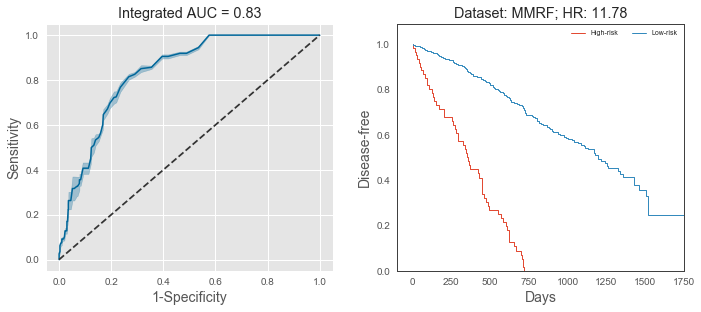

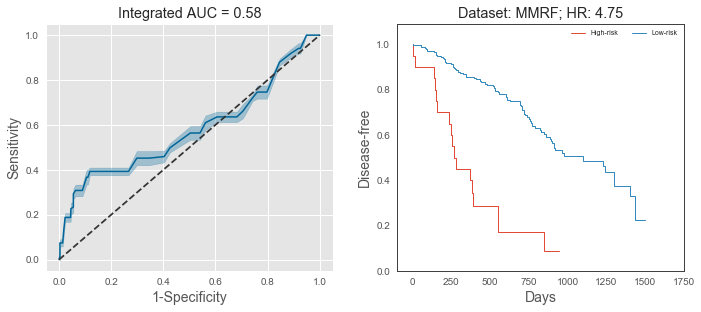

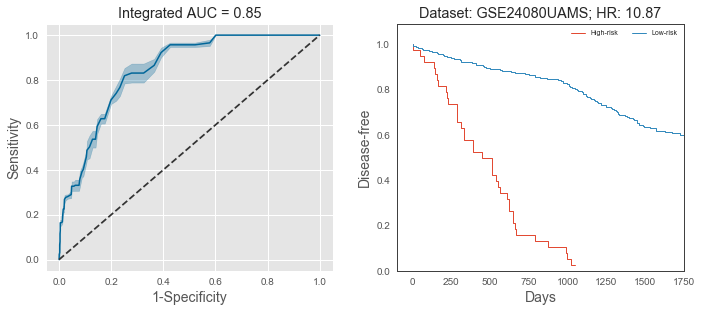

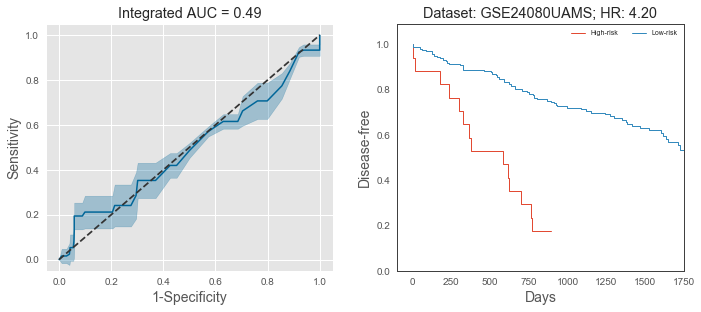

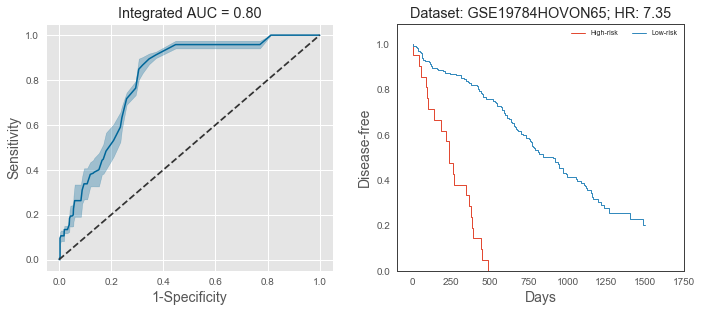

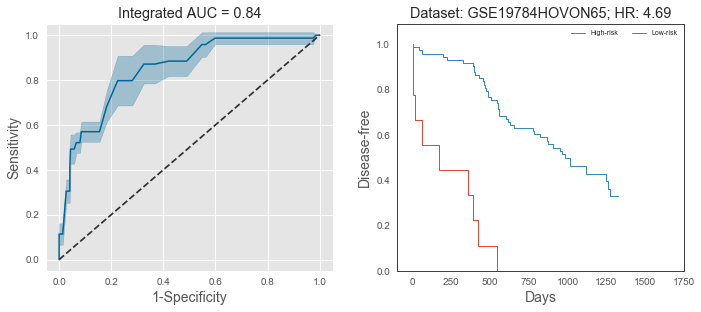

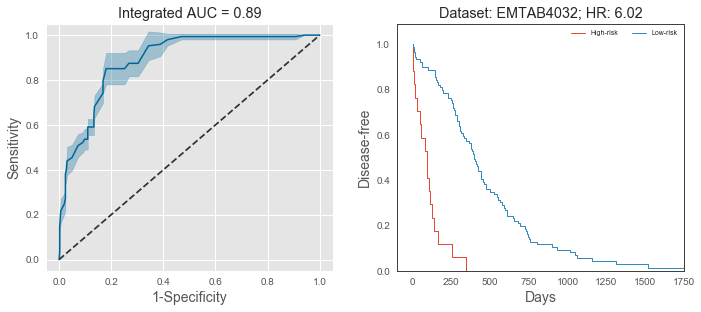

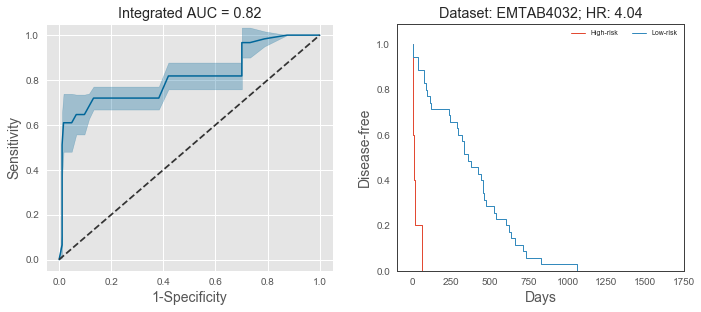

In [297]:
reload(miner)

membership_datasets = [
    overExpressedMembersMatrix,
    overExpressedMembersMatrixGSE24080UAMS,
    overExpressedMembersMatrixGSE19784HOVON65,
    overExpressedMembersMatrixEMTAB4032
]

survival_datasets = [
    guanSurvivalDfMMRF,
    guanSurvivalDfGSE24080UAMS,
    guanSurvivalDfGSE19784HOVON65,
    guanSurvivalDfEMTAB4032
]

dataset_labels = [
    "MMRF",
    "GSE24080UAMS",
    "GSE19784HOVON65",
    "EMTAB4032"
]

classifier, class0, class1, mean_aucs, mean_hrs, pct_labeled = miner.generatePredictor(membership_datasets,survival_datasets,dataset_labels,iterations = 30,method='xgboost',output_directory=resultsDirectory,metric='hazard_ratio',separate_results=True,class1_proportion=0.30,test_proportion=0.30,best_state=11)

### Evaluate classifications in each separate dataset

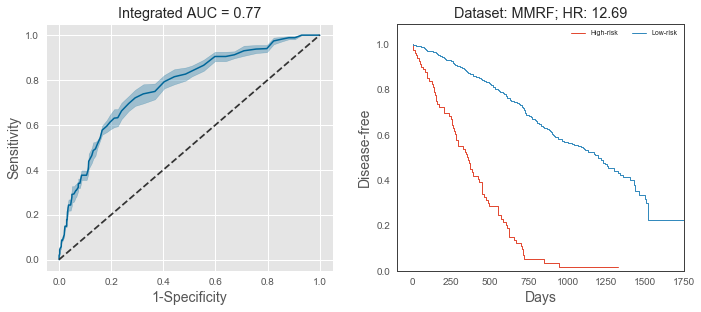

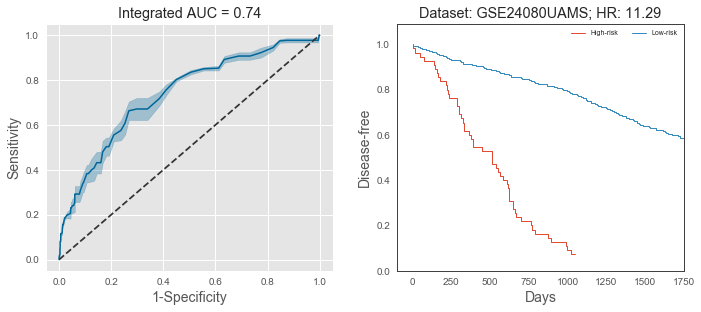

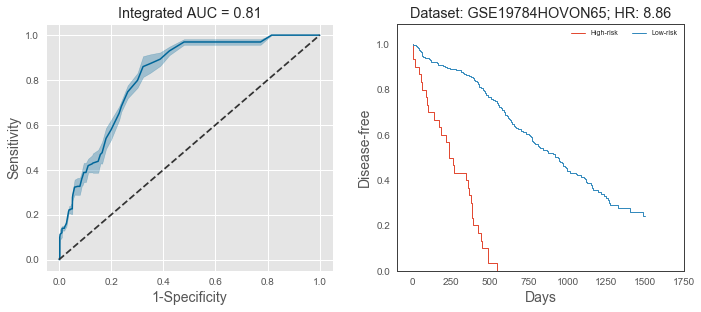

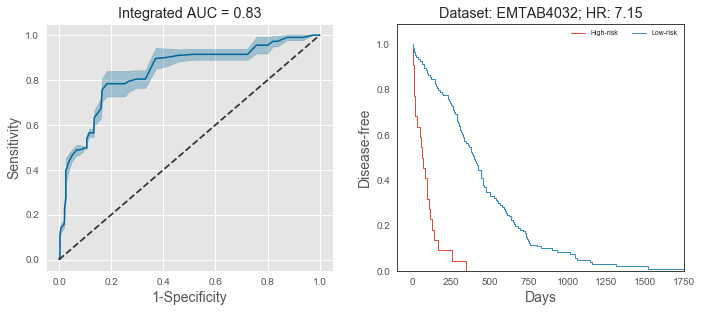

In [298]:
membership_datasets = [
    overExpressedMembersMatrix,
    overExpressedMembersMatrixGSE24080UAMS,
    overExpressedMembersMatrixGSE19784HOVON65,
    overExpressedMembersMatrixEMTAB4032
]

survival_datasets = [
    guanSurvivalDfMMRF,
    guanSurvivalDfGSE24080UAMS,
    guanSurvivalDfGSE19784HOVON65,
    guanSurvivalDfEMTAB4032
]

dataset_labels = [
    "MMRF",
    "GSE24080UAMS",
    "GSE19784HOVON65",
    "EMTAB4032"
]

predictions = []
for p in range(len(membership_datasets)):
    tmp_predictions = classifier.predict(np.array(membership_datasets[p].T))
    predictions.append(tmp_predictions)

for j in range(len(membership_datasets)):
    mtrx = membership_datasets[j]
    guan_srv = survival_datasets[j]
    survival_tag = dataset_labels[j]
    lbls = predictions[j]
    aucs, cutoffs, tpr_list, fpr_list, hazard_ratio = miner.riskStratification(lbls,mtrx,guan_srv,survival_tag,classifier,guan_rank=False,resultsDirectory=None,plot_all=False,plot_any=True)


## Determine percent predicted high-risk

In [299]:
# generate predictions for each dataset
reload(miner)
predictor_tag = "IA12"
mmrfIA12_predictions = classifier.predict(np.array(overExpressedMembersMatrix.T))
GSE24080UAMS_predictions = classifier.predict(np.array(overExpressedMembersMatrixGSE24080UAMS.T))
GSE19784HOVON65_predictions = classifier.predict(np.array(overExpressedMembersMatrixGSE19784HOVON65.T))
EMTAB4032_predictions = classifier.predict(np.array(overExpressedMembersMatrixEMTAB4032.T))

percent_classified_hr = 100*sum(mmrfIA12_predictions)/float(len(mmrfIA12_predictions))
print('classified {:.1f} percent of population as high-risk'.format(percent_classified_hr))
percent_classified_hr = 100*sum(GSE24080UAMS_predictions)/float(len(GSE24080UAMS_predictions))
print('classified {:.1f} percent of population as high-risk'.format(percent_classified_hr))
percent_classified_hr = 100*sum(GSE19784HOVON65_predictions)/float(len(GSE19784HOVON65_predictions))
print('classified {:.1f} percent of population as high-risk'.format(percent_classified_hr))
percent_classified_hr = 100*sum(EMTAB4032_predictions)/float(len(EMTAB4032_predictions))
print('classified {:.1f} percent of population as high-risk'.format(percent_classified_hr))

classified 13.6 percent of population as high-risk
classified 9.8 percent of population as high-risk
classified 10.6 percent of population as high-risk
classified 15.0 percent of population as high-risk


### Visualize decision-tree

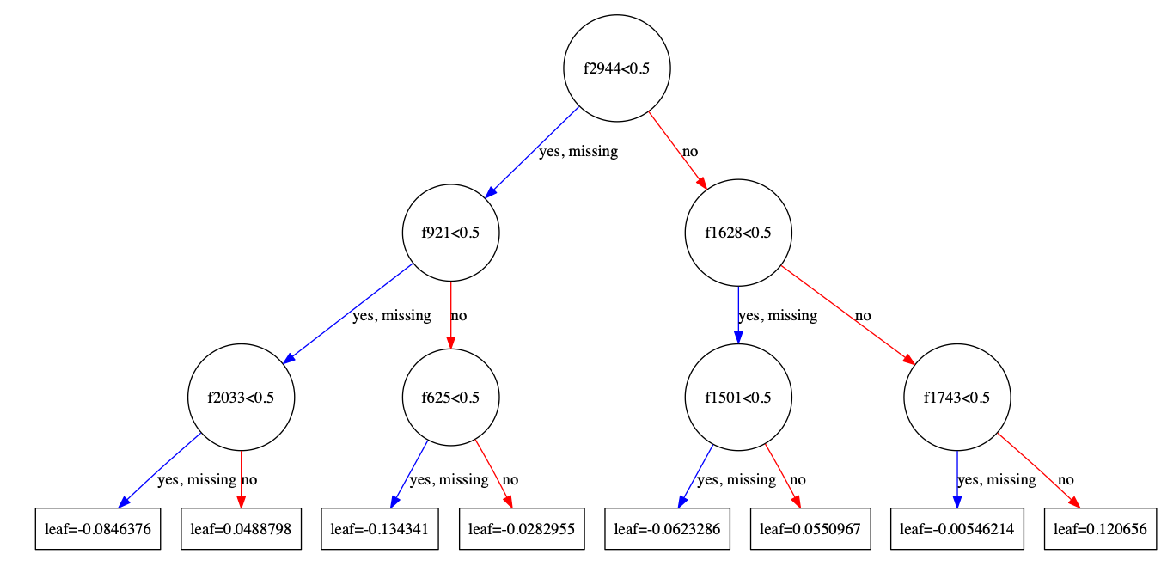

In [281]:
from xgboost import plot_tree
plot_tree(classifier, num_trees=1)
fig = plt.gcf()
fig.set_size_inches(50, 10)
# plt.savefig(os.path.join(resultsDirectory,"xgboost_tree_0.pdf"))

### Save predictor

In [282]:
# save the model to disk
filename = os.path.join(resultsDirectory,'miner_xgboost_alldata_predictor.pkl')
pickle.dump(classifier, open(filename, 'wb'))

# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))


## Investigate feature importance

### Quantify importance of each predictive feature

In [300]:
# Quantify importance of individual features
rank = 1 # 1 is the most important feature, -1 is the least important non-zero feature
fi = np.array(classifier.feature_importances_)
feature = overExpressedMembersMatrix.index[np.argsort(fi)[-rank]]
print(feature,fi[np.argsort(fi)[-rank]])

(142, 0.022988506)


### Tabulate feature importances into dataframe

In [301]:
# Tabulate important features into dataframe
fi_df = pd.DataFrame(fi)
fi_df.index = overExpressedMembersMatrix.index
fi_df.columns = ["feature_importance"]
fi_df_filtered = fi_df[fi_df["feature_importance"]>0]
fi_df_filtered.index

Int64Index([   4,    6,   21,   27,   32,   46,   64,   97,  103,  107,
            ...
            2959, 2968, 3010, 3028, 3046, 3065, 3073, 3076, 3087, 3199],
           dtype='int64', length=171)

### List number of times individual genes and regulators appear in important features


In [305]:
regulonDf_indexed = regulonDf.copy()
regulonDf_indexed.index = list(regulonDf.Regulon_ID)

allgenes = []
allregulators = []
for reg_id in list(fi_df_filtered.index):
    genes = list(regulonDf_indexed.loc[reg_id,"Gene"])
    regulator = list(regulonDf_indexed.loc[reg_id,"Regulator"])[0]
    allgenes.append(genes)
    allregulators.append(regulator)
    
count_genes = Counter(np.hstack(allgenes))
count_regulators = Counter(allregulators)

genes_mc = count_genes.most_common()
regulators_mc = count_regulators.most_common()
print(genes_mc[0:30],regulators_mc[0:30])

([('ENSG00000143756', 5), ('ENSG00000012048', 5), ('ENSG00000281540', 5), ('ENSG00000167522', 4), ('ENSG00000162607', 4), ('ENSG00000197170', 4), ('ENSG00000101752', 4), ('ENSG00000102007', 4), ('ENSG00000165660', 4), ('ENSG00000121579', 4), ('ENSG00000168159', 4), ('ENSG00000010818', 4), ('ENSG00000198961', 4), ('ENSG00000109685', 4), ('ENSG00000173402', 4), ('ENSG00000175832', 4), ('ENSG00000185753', 4), ('ENSG00000166483', 4), ('ENSG00000111445', 4), ('ENSG00000135968', 4), ('ENSG00000184675', 4), ('ENSG00000176887', 4), ('ENSG00000283021', 4), ('ENSG00000113810', 4), ('ENSG00000173442', 4), ('ENSG00000166562', 4), ('ENSG00000140105', 4), ('ENSG00000138767', 4), ('ENSG00000159259', 4), ('ENSG00000047315', 4)], [('ENSG00000066336', 4), ('ENSG00000185591', 3), ('ENSG00000282899', 3), ('ENSG00000123268', 3), ('ENSG00000153879', 3), ('ENSG00000166211', 3), ('ENSG00000126767', 3), ('ENSG00000134954', 2), ('ENSG00000151702', 2), ('ENSG00000137309', 2), ('ENSG00000178573', 2), ('ENSG000001

### Convert gene identifiers to gene symbols for reference

In [306]:
# requires installation of "mygene"

number_of_results = 30 #number of genes/regulators to convert
conv_ = [i[0] for i in genes_mc[0:number_of_results]]
#conv_ = [i[0] for i in regulators_mc[0:number_of_results]]

geneset = miner.gene_conversion(conv_,list_symbols=True)
np.savetxt(os.path.join(resultsDirectory,"geneset.txt"),geneset,fmt="%1.50s")
print(geneset)

querying 1-30...done.
Finished.
[u'FBXO28', u'BRCA1', u'RCC2', u'ANKRD11', u'USP1', u'PSMD12', u'MIB1', u'PLP2', u'ABRAXAS2', u'NAA50', u'RNF187', u'HIVEP2', u'PJA2', u'NSD2', u'DAG1', u'ETV4', u'CXorf38', u'WEE1', u'RFC5', u'GCC2', u'AMER1', u'SOX11', u'FBXO27', u'SMC4', u'EHBP1L1', u'SEC11C', u'WARS', u'CNOT6L', u'CHAF1B', u'POLR2B']


### 2b. Individual dataset prediction

## MMRF primary data

(6, 0.7191245556676689, 6.0303524995342)
classified 9.5 percent of training population as high-risk
classified 6.5 percent of test population as high-risk
6


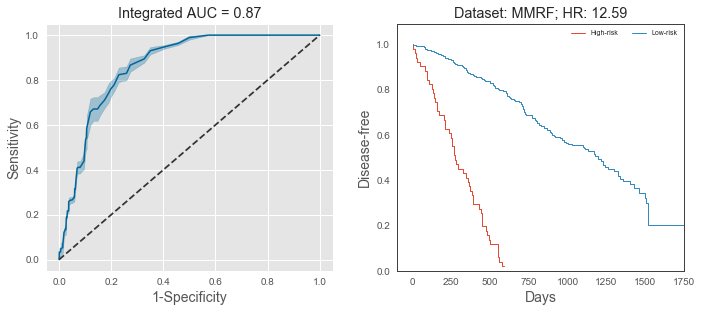

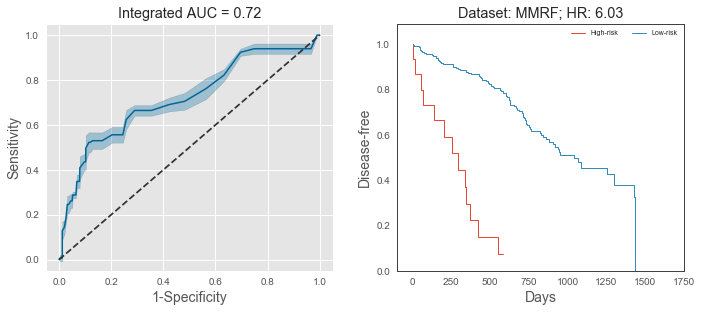

In [118]:
reload(miner)

membership_datasets = [
    overExpressedMembersMatrix,
]

survival_datasets = [
    guanSurvivalDfMMRF,
]

dataset_labels = [
    "MMRF",
]

classifier, class0, class1, mean_aucs, mean_hrs, pct_labeled = miner.generatePredictor(membership_datasets,survival_datasets,dataset_labels,iterations = 30,method='xgboost',output_directory=resultsDirectory,metric='hazard_ratio',separate_results=True,class1_proportion=0.25,test_proportion=0.30,best_state=6)

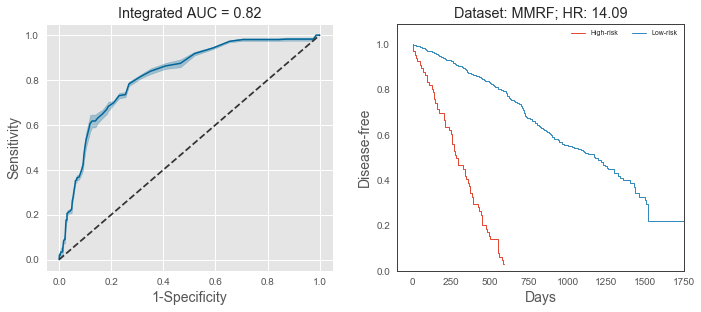

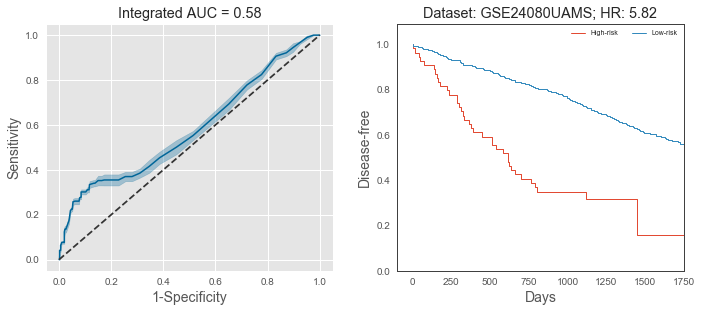

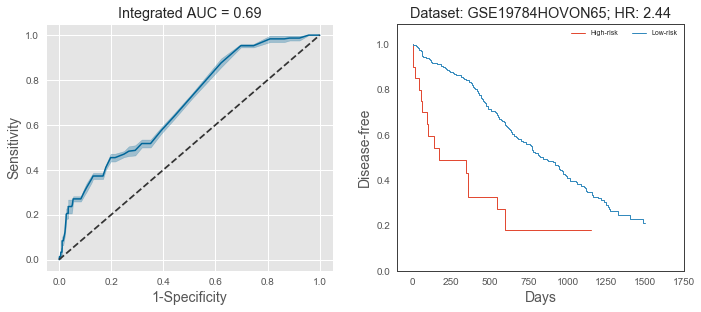

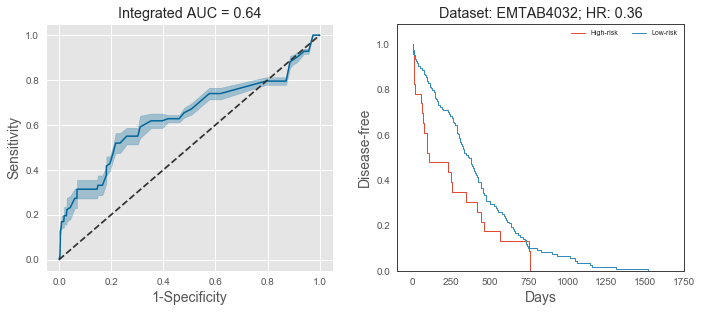

In [119]:
membership_datasets = [
    overExpressedMembersMatrix,
    overExpressedMembersMatrixGSE24080UAMS,
    overExpressedMembersMatrixGSE19784HOVON65,
    overExpressedMembersMatrixEMTAB4032
]

survival_datasets = [
    guanSurvivalDfMMRF,
    guanSurvivalDfGSE24080UAMS,
    guanSurvivalDfGSE19784HOVON65,
    guanSurvivalDfEMTAB4032
]

dataset_labels = [
    "MMRF",
    "GSE24080UAMS",
    "GSE19784HOVON65",
    "EMTAB4032"
]

predictions = []
for p in range(len(membership_datasets)):
    tmp_predictions = classifier.predict(np.array(membership_datasets[p].T))
    predictions.append(tmp_predictions)

for j in range(len(membership_datasets)):
    mtrx = membership_datasets[j]
    guan_srv = survival_datasets[j]
    survival_tag = dataset_labels[j]
    lbls = predictions[j]
    aucs, cutoffs, tpr_list, fpr_list, hazard_ratio = miner.riskStratification(lbls,mtrx,guan_srv,survival_tag,classifier,guan_rank=False,resultsDirectory=None,plot_all=False,plot_any=True)


## Determine percent predicted high-risk

In [120]:
# generate predictions for each dataset
reload(miner)
predictor_tag = "IA12"
mmrfIA12_predictions = classifier.predict(np.array(overExpressedMembersMatrix.T))
GSE24080UAMS_predictions = classifier.predict(np.array(overExpressedMembersMatrixGSE24080UAMS.T))
GSE19784HOVON65_predictions = classifier.predict(np.array(overExpressedMembersMatrixGSE19784HOVON65.T))
EMTAB4032_predictions = classifier.predict(np.array(overExpressedMembersMatrixEMTAB4032.T))

percent_classified_hr = 100*sum(mmrfIA12_predictions)/float(len(mmrfIA12_predictions))
print('classified {:.1f} percent of population as high-risk'.format(percent_classified_hr))
percent_classified_hr = 100*sum(GSE24080UAMS_predictions)/float(len(GSE24080UAMS_predictions))
print('classified {:.1f} percent of population as high-risk'.format(percent_classified_hr))
percent_classified_hr = 100*sum(GSE19784HOVON65_predictions)/float(len(GSE19784HOVON65_predictions))
print('classified {:.1f} percent of population as high-risk'.format(percent_classified_hr))
percent_classified_hr = 100*sum(EMTAB4032_predictions)/float(len(EMTAB4032_predictions))
print('classified {:.1f} percent of population as high-risk'.format(percent_classified_hr))

classified 10.8 percent of population as high-risk
classified 9.7 percent of population as high-risk
classified 7.1 percent of population as high-risk
classified 15.6 percent of population as high-risk


### Visualize decision-tree

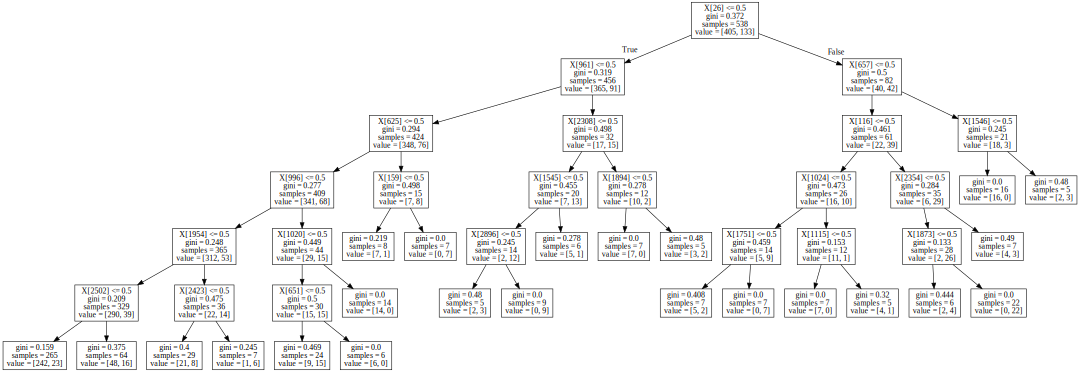

In [44]:
from xgboost import plot_tree
plot_tree(classifier, num_trees=1)
fig = plt.gcf()
fig.set_size_inches(50, 10)
# plt.savefig(os.path.join(resultsDirectory,"xgboost_tree_0.pdf"))

### Save predictor

In [31]:
# save the model to disk
filename = os.path.join(resultsDirectory,'miner_decisionTree_predictor.pkl')
pickle.dump(classifier, open(filename, 'wb'))

# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))


## Investigate feature importance

### Quantify importance of each predictive feature

In [121]:
# Quantify importance of individual features
rank = 1 # 1 is the most important feature, -1 is the least important non-zero feature
fi = np.array(classifier.feature_importances_)
feature = overExpressedMembersMatrix.index[np.argsort(fi)[-rank]]
print(feature,fi[np.argsort(fi)[-rank]])

(1223, 0.039215688)


### Tabulate feature importances into dataframe

In [122]:
# Tabulate important features into dataframe
fi_df = pd.DataFrame(fi)
fi_df.index = overExpressedMembersMatrix.index
fi_df.columns = ["feature_importance"]
fi_df_filtered = fi_df[fi_df["feature_importance"]>0]
fi_df_filtered.index

Int64Index([   4,   26,   97,  116,  122,  128,  146,  201,  202,  248,  257,
             285,  298,  361,  415,  485,  490,  493,  539,  586,  593,  597,
             619,  625,  634,  653,  711,  742,  821,  830,  839,  866,  961,
            1058, 1061, 1069, 1133, 1208, 1223, 1242, 1248, 1264, 1288, 1305,
            1308, 1327, 1351, 1379, 1459, 1474, 1553, 1559, 1568, 1579, 1627,
            1628, 1663, 1688, 1716, 1735, 1738, 1743, 1750, 1770, 1818, 1903,
            1905, 1921, 1932, 1954, 2025, 2032, 2048, 2107, 2108, 2109, 2170,
            2172, 2210, 2224, 2375, 2404, 2423, 2492, 2540, 2577, 2685, 2699,
            2710, 2712, 2720, 2755, 2771, 2778, 2846, 2990, 3003, 3057, 3155,
            3173],
           dtype='int64')

### List number of times individual genes and regulators appear in important features


In [123]:
regulonDf_indexed = regulonDf.copy()
regulonDf_indexed.index = list(regulonDf.Regulon_ID)

allgenes = []
allregulators = []
for reg_id in list(fi_df_filtered.index):
    genes = list(regulonDf_indexed.loc[reg_id,"Gene"])
    regulator = list(regulonDf_indexed.loc[reg_id,"Regulator"])[0]
    allgenes.append(genes)
    allregulators.append(regulator)
    
count_genes = Counter(np.hstack(allgenes))
count_regulators = Counter(allregulators)

genes_mc = count_genes.most_common()
regulators_mc = count_regulators.most_common()
print(genes_mc[0:10],regulators_mc[0:10])

([('ENSG00000138814', 6), ('ENSG00000113810', 5), ('ENSG00000281540', 5), ('ENSG00000166483', 5), ('ENSG00000176887', 5), ('ENSG00000012048', 4), ('ENSG00000070756', 4), ('ENSG00000175832', 4), ('ENSG00000047315', 4), ('ENSG00000111445', 4)], [('ENSG00000185630', 3), ('ENSG00000204103', 3), ('ENSG00000179348', 3), ('ENSG00000166888', 2), ('ENSG00000109906', 2), ('ENSG00000185591', 2), ('ENSG00000118513', 2), ('ENSG00000157557', 2), ('ENSG00000137265', 2), ('ENSG00000137309', 2)])


### Convert gene identifiers to gene symbols for reference

In [125]:
# requires installation of "mygene"

number_of_results = 30 #number of genes/regulators to convert
conv_ = [i[0] for i in genes_mc[0:number_of_results]]
#conv_ = [i[0] for i in regulators_mc[0:number_of_results]]

geneset = miner.gene_conversion(conv_,list_symbols=True)
np.savetxt(os.path.join(resultsDirectory,"geneset.txt"),geneset,fmt="%1.50s")
print(geneset)

querying 1-30...done.
Finished.
[u'PPP3CA', u'SMC4', u'RCC2', u'WEE1', u'SOX11', u'BRCA1', u'PABPC1', u'ETV4', u'POLR2B', u'RFC5', u'NSD2', u'EED', u'HELLS', u'PANX1', u'SMARCE1', u'SETD1B', u'USP1', u'RASAL3', u'PCNA', u'YWHAQ', u'DIPK2A', u'CALM1', u'MXI1', u'STMN1', u'SEC11C', u'SP2', u'WARS', u'DTL', u'ATXN2L', u'PLOD2']


## GSE24080UAMS test data

(29, 0.6920420892172536, 3.629087349345512)
classified 11.3 percent of training population as high-risk
classified 11.3 percent of test population as high-risk
29


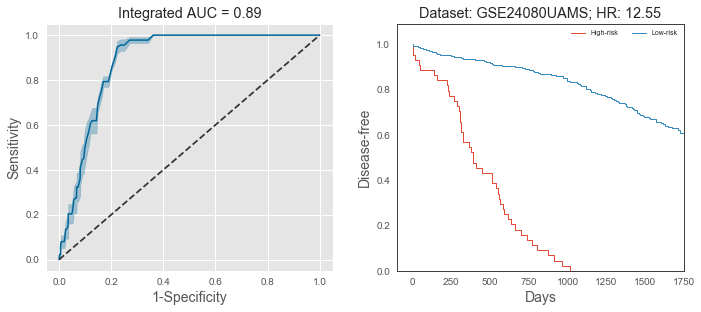

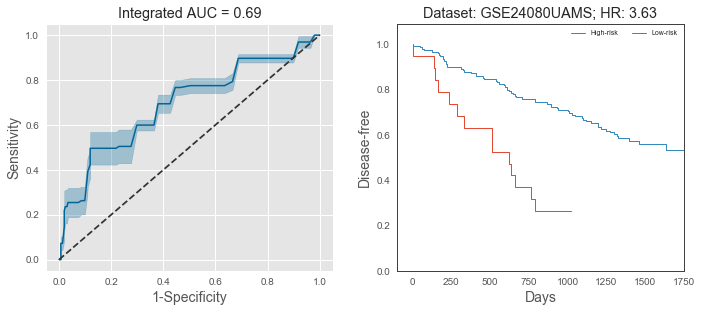

In [174]:
reload(miner)

membership_datasets = [
    overExpressedMembersMatrixGSE24080UAMS,
]

survival_datasets = [
    guanSurvivalDfGSE24080UAMS,
]

dataset_labels = [
    "GSE24080UAMS",
]

classifier, class0, class1, mean_aucs, mean_hrs, pct_labeled = miner.generatePredictor(membership_datasets,survival_datasets,dataset_labels,iterations = 30,method='xgboost',output_directory=resultsDirectory,metric='hazard_ratio',separate_results=True,class1_proportion=0.30,test_proportion=0.30,best_state=29)

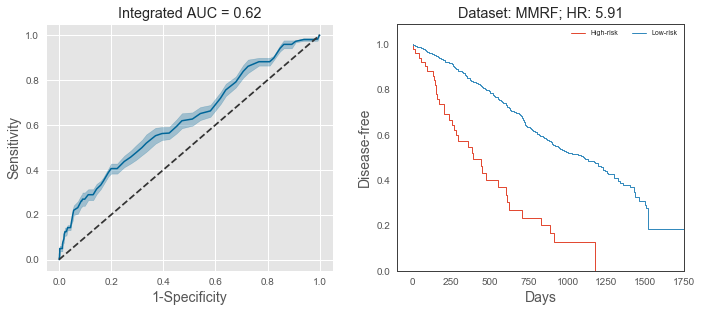

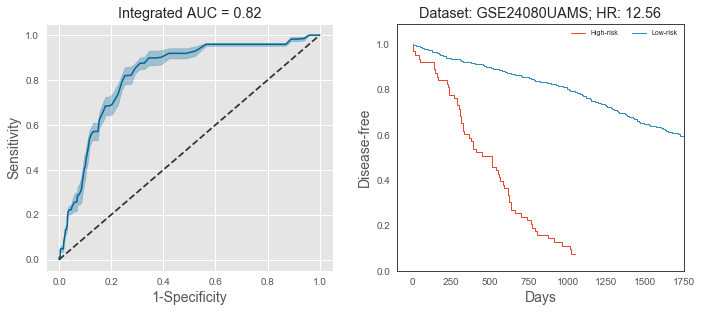

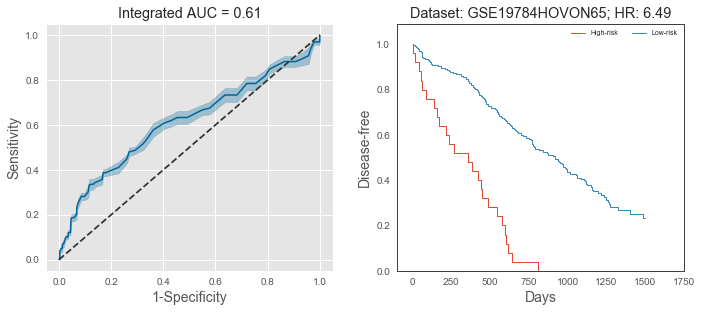

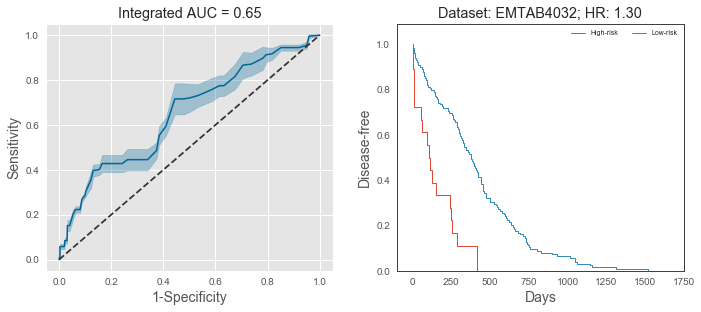

In [175]:
membership_datasets = [
    overExpressedMembersMatrix,
    overExpressedMembersMatrixGSE24080UAMS,
    overExpressedMembersMatrixGSE19784HOVON65,
    overExpressedMembersMatrixEMTAB4032
]

survival_datasets = [
    guanSurvivalDfMMRF,
    guanSurvivalDfGSE24080UAMS,
    guanSurvivalDfGSE19784HOVON65,
    guanSurvivalDfEMTAB4032
]

dataset_labels = [
    "MMRF",
    "GSE24080UAMS",
    "GSE19784HOVON65",
    "EMTAB4032"
]

predictions = []
for p in range(len(membership_datasets)):
    tmp_predictions = classifier.predict(np.array(membership_datasets[p].T))
    predictions.append(tmp_predictions)

for j in range(len(membership_datasets)):
    mtrx = membership_datasets[j]
    guan_srv = survival_datasets[j]
    survival_tag = dataset_labels[j]
    lbls = predictions[j]
    aucs, cutoffs, tpr_list, fpr_list, hazard_ratio = miner.riskStratification(lbls,mtrx,guan_srv,survival_tag,classifier,guan_rank=False,resultsDirectory=None,plot_all=False,plot_any=True)


## Determine percent predicted high-risk

In [176]:
# generate predictions for each dataset
reload(miner)
predictor_tag = "IA12"
mmrfIA12_predictions = classifier.predict(np.array(overExpressedMembersMatrix.T))
GSE24080UAMS_predictions = classifier.predict(np.array(overExpressedMembersMatrixGSE24080UAMS.T))
GSE19784HOVON65_predictions = classifier.predict(np.array(overExpressedMembersMatrixGSE19784HOVON65.T))
EMTAB4032_predictions = classifier.predict(np.array(overExpressedMembersMatrixEMTAB4032.T))

percent_classified_hr = 100*sum(mmrfIA12_predictions)/float(len(mmrfIA12_predictions))
print('classified {:.1f} percent of population as high-risk'.format(percent_classified_hr))
percent_classified_hr = 100*sum(GSE24080UAMS_predictions)/float(len(GSE24080UAMS_predictions))
print('classified {:.1f} percent of population as high-risk'.format(percent_classified_hr))
percent_classified_hr = 100*sum(GSE19784HOVON65_predictions)/float(len(GSE19784HOVON65_predictions))
print('classified {:.1f} percent of population as high-risk'.format(percent_classified_hr))
percent_classified_hr = 100*sum(EMTAB4032_predictions)/float(len(EMTAB4032_predictions))
print('classified {:.1f} percent of population as high-risk'.format(percent_classified_hr))

classified 9.0 percent of population as high-risk
classified 11.3 percent of population as high-risk
classified 8.9 percent of population as high-risk
classified 12.2 percent of population as high-risk


### Visualize decision-tree

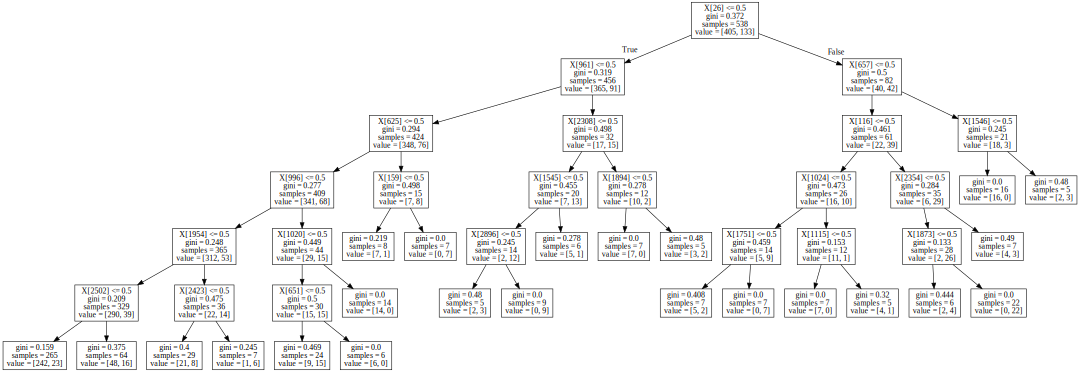

In [44]:
from xgboost import plot_tree
plot_tree(classifier, num_trees=1)
fig = plt.gcf()
fig.set_size_inches(50, 10)
# plt.savefig(os.path.join(resultsDirectory,"xgboost_tree_0.pdf"))

### Save predictor

In [31]:
# save the model to disk
filename = os.path.join(resultsDirectory,'miner_decisionTree_predictor.pkl')
pickle.dump(classifier, open(filename, 'wb'))

# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))


## Investigate feature importance

### Quantify importance of each predictive feature

In [177]:
# Quantify importance of individual features
rank = 1 # 1 is the most important feature, -1 is the least important non-zero feature
fi = np.array(classifier.feature_importances_)
feature = overExpressedMembersMatrix.index[np.argsort(fi)[-rank]]
print(feature,fi[np.argsort(fi)[-rank]])

(606, 0.036585364)


### Tabulate feature importances into dataframe

In [178]:
# Tabulate important features into dataframe
fi_df = pd.DataFrame(fi)
fi_df.index = overExpressedMembersMatrix.index
fi_df.columns = ["feature_importance"]
fi_df_filtered = fi_df[fi_df["feature_importance"]>0]
fi_df_filtered.index

Int64Index([  16,   31,   38,   67,   97,  107,  110,  151,  172,  235,
            ...
            2915, 2926, 2945, 2947, 2974, 3027, 3032, 3041, 3065, 3103],
           dtype='int64', length=115)

### List number of times individual genes and regulators appear in important features


In [179]:
regulonDf_indexed = regulonDf.copy()
regulonDf_indexed.index = list(regulonDf.Regulon_ID)

allgenes = []
allregulators = []
for reg_id in list(fi_df_filtered.index):
    genes = list(regulonDf_indexed.loc[reg_id,"Gene"])
    regulator = list(regulonDf_indexed.loc[reg_id,"Regulator"])[0]
    allgenes.append(genes)
    allregulators.append(regulator)
    
count_genes = Counter(np.hstack(allgenes))
count_regulators = Counter(allregulators)

genes_mc = count_genes.most_common()
regulators_mc = count_regulators.most_common()
print(genes_mc[0:10],regulators_mc[0:10])

([('ENSG00000183023', 4), ('ENSG00000177565', 4), ('ENSG00000135686', 4), ('ENSG00000147576', 4), ('ENSG00000145349', 4), ('ENSG00000178971', 4), ('ENSG00000144791', 4), ('ENSG00000112679', 4), ('ENSG00000117519', 4), ('ENSG00000109046', 4)], [('ENSG00000137203', 3), ('ENSG00000119725', 3), ('ENSG00000104064', 2), ('ENSG00000131759', 2), ('ENSG00000101096', 2), ('ENSG00000118260', 2), ('ENSG00000109381', 2), ('ENSG00000105722', 2), ('ENSG00000109906', 2), ('ENSG00000129514', 2)])


### Convert gene identifiers to gene symbols for reference

In [181]:
# requires installation of "mygene"

number_of_results = 30 #number of genes/regulators to convert
conv_ = [i[0] for i in genes_mc[0:number_of_results]]
conv_ = [i[0] for i in regulators_mc[0:number_of_results]]

geneset = miner.gene_conversion(conv_,list_symbols=True)
np.savetxt(os.path.join(resultsDirectory,"geneset.txt"),geneset,fmt="%1.50s")
print(geneset)

querying 1-30...done.
Finished.
[u'TFAP2A', u'ZNF410', u'GABPB1', u'RARA', u'NFATC2', u'CREB1', u'ELF2', u'ERF', u'ZBTB16', u'FOXA1', u'BCL6', u'E2F2', u'IRX5', u'SPIB', u'ETV6', u'RREB1', u'HOXA6', u'HIC1', u'KLF15', u'GATA4', u'ESR1', u'PAX5', u'FLI1', u'POU2F1', u'HOXA10', u'ZBTB12', u'HMGA1', u'ZBTB14', u'MAF', u'ESRRG']


## GSE19784HOVON65 test data

(4, 0.6948660184270282, 3.811539667666544)
classified 19.8 percent of training population as high-risk
classified 16.5 percent of test population as high-risk
4


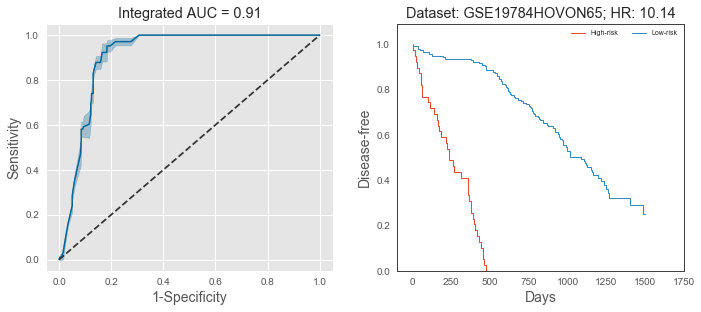

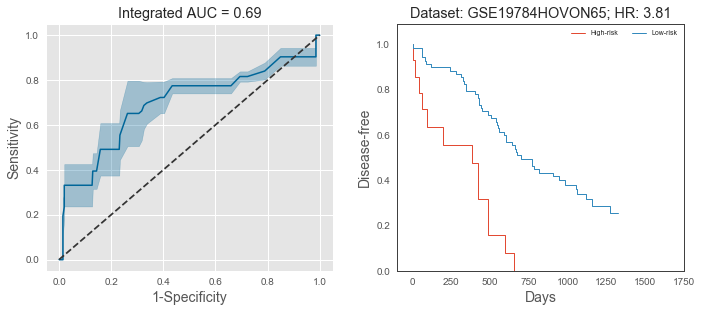

In [225]:
reload(miner)

membership_datasets = [
    overExpressedMembersMatrixGSE19784HOVON65,
]

survival_datasets = [
    guanSurvivalDfGSE19784HOVON65,
]

dataset_labels = [
    "GSE19784HOVON65",
]

classifier, class0, class1, mean_aucs, mean_hrs, pct_labeled = miner.generatePredictor(membership_datasets,survival_datasets,dataset_labels,iterations = 30,method='xgboost',output_directory=resultsDirectory,metric='hazard_ratio',separate_results=True,class1_proportion=0.30,test_proportion=0.30,best_state=4)

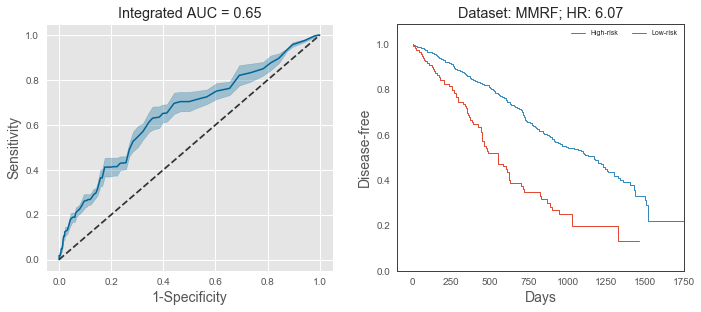

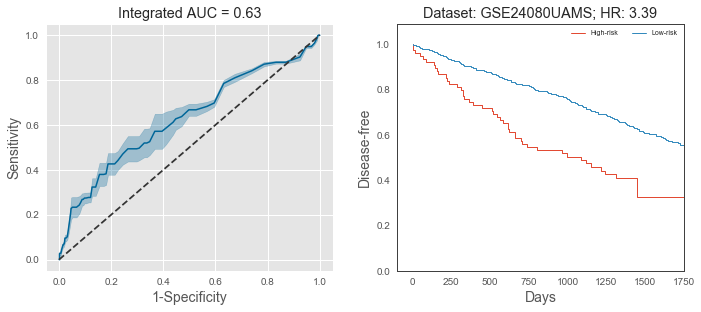

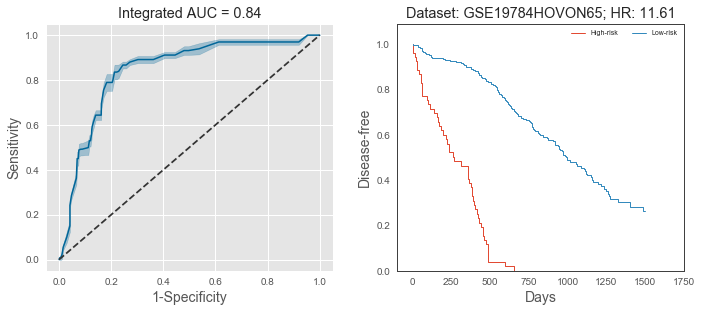

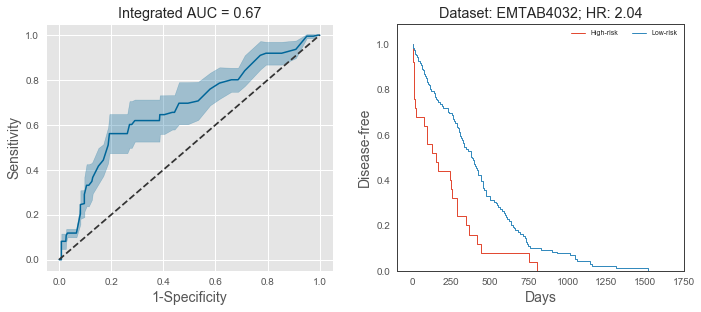

In [226]:
membership_datasets = [
    overExpressedMembersMatrix,
    overExpressedMembersMatrixGSE24080UAMS,
    overExpressedMembersMatrixGSE19784HOVON65,
    overExpressedMembersMatrixEMTAB4032
]

survival_datasets = [
    guanSurvivalDfMMRF,
    guanSurvivalDfGSE24080UAMS,
    guanSurvivalDfGSE19784HOVON65,
    guanSurvivalDfEMTAB4032
]

dataset_labels = [
    "MMRF",
    "GSE24080UAMS",
    "GSE19784HOVON65",
    "EMTAB4032"
]

predictions = []
for p in range(len(membership_datasets)):
    tmp_predictions = classifier.predict(np.array(membership_datasets[p].T))
    predictions.append(tmp_predictions)

for j in range(len(membership_datasets)):
    mtrx = membership_datasets[j]
    guan_srv = survival_datasets[j]
    survival_tag = dataset_labels[j]
    lbls = predictions[j]
    aucs, cutoffs, tpr_list, fpr_list, hazard_ratio = miner.riskStratification(lbls,mtrx,guan_srv,survival_tag,classifier,guan_rank=False,resultsDirectory=None,plot_all=False,plot_any=True)


## Determine percent predicted high-risk

In [227]:
# generate predictions for each dataset
reload(miner)
predictor_tag = "IA12"
mmrfIA12_predictions = classifier.predict(np.array(overExpressedMembersMatrix.T))
GSE24080UAMS_predictions = classifier.predict(np.array(overExpressedMembersMatrixGSE24080UAMS.T))
GSE19784HOVON65_predictions = classifier.predict(np.array(overExpressedMembersMatrixGSE19784HOVON65.T))
EMTAB4032_predictions = classifier.predict(np.array(overExpressedMembersMatrixEMTAB4032.T))

percent_classified_hr = 100*sum(mmrfIA12_predictions)/float(len(mmrfIA12_predictions))
print('classified {:.1f} percent of population as high-risk'.format(percent_classified_hr))
percent_classified_hr = 100*sum(GSE24080UAMS_predictions)/float(len(GSE24080UAMS_predictions))
print('classified {:.1f} percent of population as high-risk'.format(percent_classified_hr))
percent_classified_hr = 100*sum(GSE19784HOVON65_predictions)/float(len(GSE19784HOVON65_predictions))
print('classified {:.1f} percent of population as high-risk'.format(percent_classified_hr))
percent_classified_hr = 100*sum(EMTAB4032_predictions)/float(len(EMTAB4032_predictions))
print('classified {:.1f} percent of population as high-risk'.format(percent_classified_hr))

classified 18.4 percent of population as high-risk
classified 13.4 percent of population as high-risk
classified 18.8 percent of population as high-risk
classified 17.0 percent of population as high-risk


### Visualize decision-tree

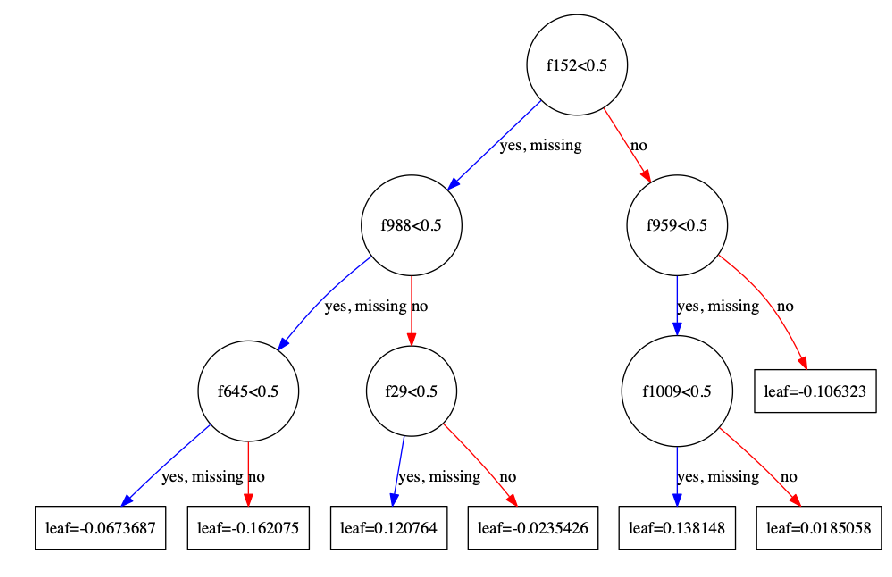

In [201]:
from xgboost import plot_tree
plot_tree(classifier, num_trees=1)
fig = plt.gcf()
fig.set_size_inches(50, 10)
# plt.savefig(os.path.join(resultsDirectory,"xgboost_tree_0.pdf"))

### Save predictor

In [31]:
# save the model to disk
filename = os.path.join(resultsDirectory,'miner_decisionTree_predictor.pkl')
pickle.dump(classifier, open(filename, 'wb'))

# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))


## Investigate feature importance

### Quantify importance of each predictive feature

In [228]:
# Quantify importance of individual features
rank = 1 # 1 is the most important feature, -1 is the least important non-zero feature
fi = np.array(classifier.feature_importances_)
feature = overExpressedMembersMatrix.index[np.argsort(fi)[-rank]]
print(feature,fi[np.argsort(fi)[-rank]])

(988, 0.03816794)


### Tabulate feature importances into dataframe

In [229]:
# Tabulate important features into dataframe
fi_df = pd.DataFrame(fi)
fi_df.index = overExpressedMembersMatrix.index
fi_df.columns = ["feature_importance"]
fi_df_filtered = fi_df[fi_df["feature_importance"]>0]
fi_df_filtered.index

Int64Index([   8,   16,   51,   85,  103,  141,  151,  167,  180,  321,  370,
             396,  397,  399,  422,  444,  450,  530,  562,  604,  645,  666,
             712,  732,  739,  742,  760,  785,  830,  835,  845,  912,  917,
             988, 1023, 1081, 1342, 1474, 1487, 1530, 1566, 1599, 1674, 1680,
            1728, 1744, 1750, 1762, 2033, 2067, 2068, 2117, 2239, 2275, 2277,
            2278, 2320, 2337, 2404, 2410, 2496, 2646, 2660, 2674, 2712, 2718,
            2734, 2735, 2736, 2781, 2789, 2819, 2848, 2911, 2922, 2943, 2954,
            2986, 3065, 3070, 3092, 3121, 3149, 3160, 3200],
           dtype='int64')

### List number of times individual genes and regulators appear in important features


In [230]:
regulonDf_indexed = regulonDf.copy()
regulonDf_indexed.index = list(regulonDf.Regulon_ID)

allgenes = []
allregulators = []
for reg_id in list(fi_df_filtered.index):
    genes = list(regulonDf_indexed.loc[reg_id,"Gene"])
    regulator = list(regulonDf_indexed.loc[reg_id,"Regulator"])[0]
    allgenes.append(genes)
    allregulators.append(regulator)
    
count_genes = Counter(np.hstack(allgenes))
count_regulators = Counter(allregulators)

genes_mc = count_genes.most_common()
regulators_mc = count_regulators.most_common()
print(genes_mc[0:10],regulators_mc[0:10])

([('ENSG00000281540', 5), ('ENSG00000139112', 4), ('ENSG00000163877', 4), ('ENSG00000173846', 3), ('ENSG00000196365', 3), ('ENSG00000069956', 3), ('ENSG00000156875', 3), ('ENSG00000065911', 3), ('ENSG00000147852', 3), ('ENSG00000168003', 3)], [('ENSG00000185591', 4), ('ENSG00000125398', 3), ('ENSG00000069667', 3), ('ENSG00000153879', 2), ('ENSG00000137309', 2), ('ENSG00000131759', 2), ('ENSG00000139651', 2), ('ENSG00000135100', 2), ('ENSG00000134954', 1), ('ENSG00000106006', 1)])


### Convert gene identifiers to gene symbols for reference

In [232]:
# requires installation of "mygene"

number_of_results = 30 #number of genes/regulators to convert
conv_ = [i[0] for i in genes_mc[0:number_of_results]]
#conv_ = [i[0] for i in regulators_mc[0:number_of_results]]

geneset = miner.gene_conversion(conv_,list_symbols=True)
np.savetxt(os.path.join(resultsDirectory,"geneset.txt"),geneset,fmt="%1.50s")
print(geneset)

querying 1-30...done.
Finished.
[u'RCC2', u'GABARAPL1', u'SNIP1', u'PLK3', u'LONP1', u'MAPK6', u'MFSD14A', u'MTHFD2', u'VLDLR', u'SLC3A2', u'SLC7A11', u'PSMD12', u'BRCA1', u'SLC1A5', u'INHBC', u'SLC7A1', u'WARS', u'MIA2', u'SMIM14', u'NDUFA4L2', u'GARS', u'PSAT1', u'INHBE', u'GPR63', u'ZBTB2', u'FAM83D', u'ATP6V1D', u'PCK2', u'SLC9A8', u'WDR76']


## EMTAB4032 test data

(21, 0.5063087012537061, 2.4360922967900427)
classified 27.5 percent of training population as high-risk
classified 11.1 percent of test population as high-risk
21


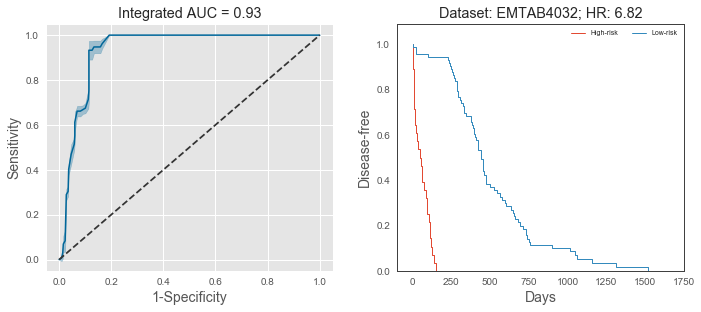

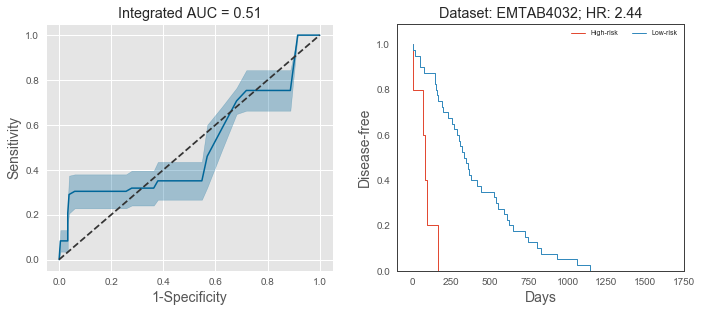

In [269]:
reload(miner)

membership_datasets = [
    overExpressedMembersMatrixEMTAB4032,
]

survival_datasets = [
    guanSurvivalDfEMTAB4032,
]

dataset_labels = [
    "EMTAB4032",
]

classifier, class0, class1, mean_aucs, mean_hrs, pct_labeled = miner.generatePredictor(membership_datasets,survival_datasets,dataset_labels,iterations = 30,method='xgboost',output_directory=resultsDirectory,metric='hazard_ratio',separate_results=True,class1_proportion=0.30,test_proportion=0.30,best_state=21)

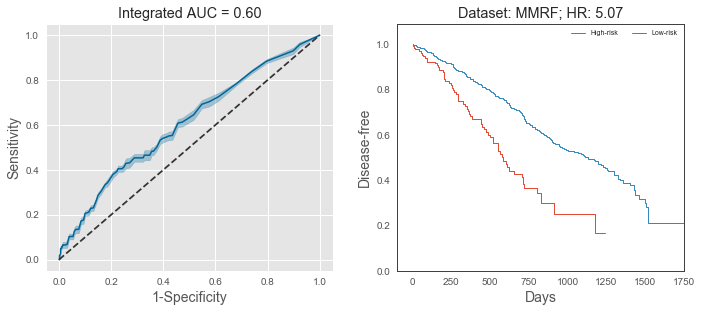

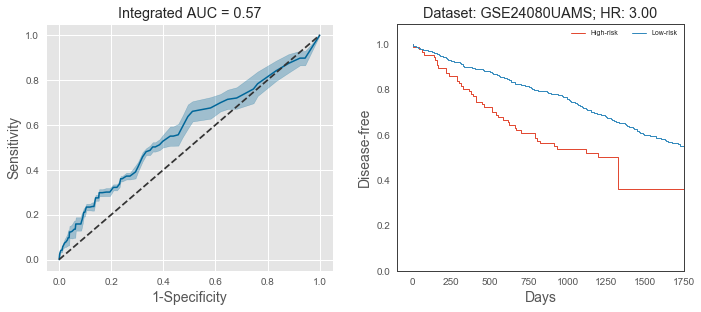

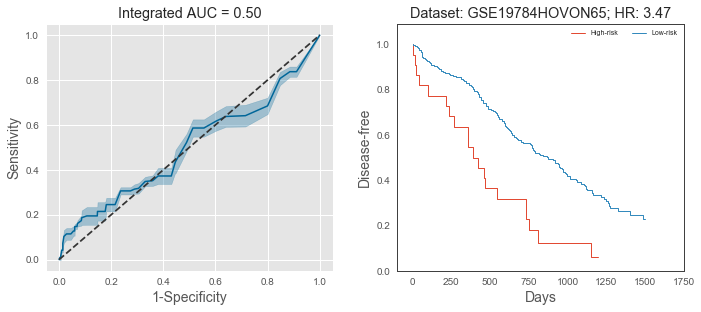

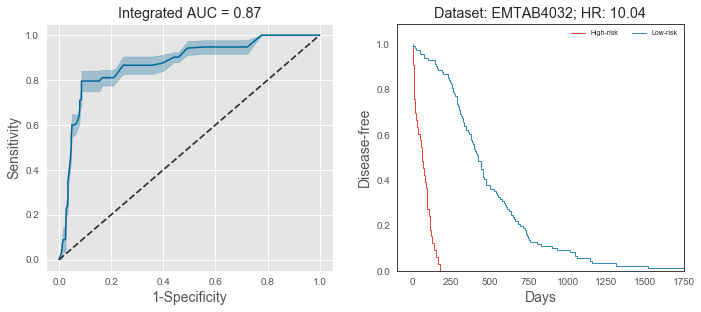

In [270]:
membership_datasets = [
    overExpressedMembersMatrix,
    overExpressedMembersMatrixGSE24080UAMS,
    overExpressedMembersMatrixGSE19784HOVON65,
    overExpressedMembersMatrixEMTAB4032
]

survival_datasets = [
    guanSurvivalDfMMRF,
    guanSurvivalDfGSE24080UAMS,
    guanSurvivalDfGSE19784HOVON65,
    guanSurvivalDfEMTAB4032
]

dataset_labels = [
    "MMRF",
    "GSE24080UAMS",
    "GSE19784HOVON65",
    "EMTAB4032"
]

predictions = []
for p in range(len(membership_datasets)):
    tmp_predictions = classifier.predict(np.array(membership_datasets[p].T))
    predictions.append(tmp_predictions)

for j in range(len(membership_datasets)):
    mtrx = membership_datasets[j]
    guan_srv = survival_datasets[j]
    survival_tag = dataset_labels[j]
    lbls = predictions[j]
    aucs, cutoffs, tpr_list, fpr_list, hazard_ratio = miner.riskStratification(lbls,mtrx,guan_srv,survival_tag,classifier,guan_rank=False,resultsDirectory=None,plot_all=False,plot_any=True)


## Determine percent predicted high-risk

In [271]:
# generate predictions for each dataset
reload(miner)
predictor_tag = "IA12"
mmrfIA12_predictions = classifier.predict(np.array(overExpressedMembersMatrix.T))
GSE24080UAMS_predictions = classifier.predict(np.array(overExpressedMembersMatrixGSE24080UAMS.T))
GSE19784HOVON65_predictions = classifier.predict(np.array(overExpressedMembersMatrixGSE19784HOVON65.T))
EMTAB4032_predictions = classifier.predict(np.array(overExpressedMembersMatrixEMTAB4032.T))

percent_classified_hr = 100*sum(mmrfIA12_predictions)/float(len(mmrfIA12_predictions))
print('classified {:.1f} percent of population as high-risk'.format(percent_classified_hr))
percent_classified_hr = 100*sum(GSE24080UAMS_predictions)/float(len(GSE24080UAMS_predictions))
print('classified {:.1f} percent of population as high-risk'.format(percent_classified_hr))
percent_classified_hr = 100*sum(GSE19784HOVON65_predictions)/float(len(GSE19784HOVON65_predictions))
print('classified {:.1f} percent of population as high-risk'.format(percent_classified_hr))
percent_classified_hr = 100*sum(EMTAB4032_predictions)/float(len(EMTAB4032_predictions))
print('classified {:.1f} percent of population as high-risk'.format(percent_classified_hr))

classified 19.5 percent of population as high-risk
classified 15.6 percent of population as high-risk
classified 7.8 percent of population as high-risk
classified 22.4 percent of population as high-risk


### Visualize decision-tree

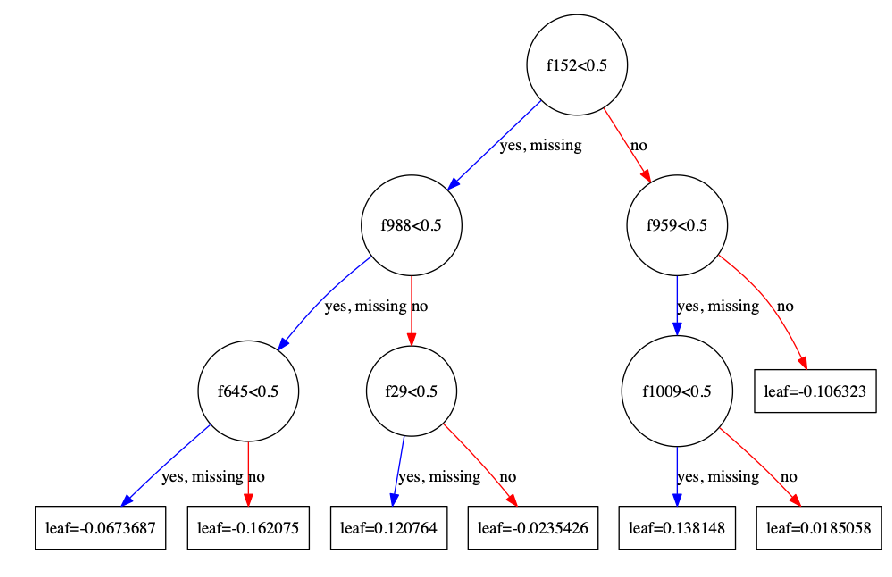

In [201]:
from xgboost import plot_tree
plot_tree(classifier, num_trees=1)
fig = plt.gcf()
fig.set_size_inches(50, 10)
# plt.savefig(os.path.join(resultsDirectory,"xgboost_tree_0.pdf"))

### Save predictor

In [31]:
# save the model to disk
filename = os.path.join(resultsDirectory,'miner_decisionTree_predictor.pkl')
pickle.dump(classifier, open(filename, 'wb'))

# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))


## Investigate feature importance

### Quantify importance of each predictive feature

In [272]:
# Quantify importance of individual features
rank = 1 # 1 is the most important feature, -1 is the least important non-zero feature
fi = np.array(classifier.feature_importances_)
feature = overExpressedMembersMatrix.index[np.argsort(fi)[-rank]]
print(feature,fi[np.argsort(fi)[-rank]])

(504, 0.08256881)


### Tabulate feature importances into dataframe

In [273]:
# Tabulate important features into dataframe
fi_df = pd.DataFrame(fi)
fi_df.index = overExpressedMembersMatrix.index
fi_df.columns = ["feature_importance"]
fi_df_filtered = fi_df[fi_df["feature_importance"]>0]
fi_df_filtered.index

Int64Index([  63,   81,  108,  117,  164,  197,  265,  352,  394,  461,  504,
             545,  700,  927,  948,  975,  995, 1096, 1162, 1201, 1212, 1366,
            1526, 1530, 1604, 1686, 1716, 1898, 1963, 1972, 2085, 2237, 2244,
            2292, 2314, 2333, 2373, 2391, 2397, 2501, 2548, 2554, 2561, 2566,
            2584, 2755, 2847, 2937, 2951, 2967, 3200],
           dtype='int64')

### List number of times individual genes and regulators appear in important features


In [274]:
regulonDf_indexed = regulonDf.copy()
regulonDf_indexed.index = list(regulonDf.Regulon_ID)

allgenes = []
allregulators = []
for reg_id in list(fi_df_filtered.index):
    genes = list(regulonDf_indexed.loc[reg_id,"Gene"])
    regulator = list(regulonDf_indexed.loc[reg_id,"Regulator"])[0]
    allgenes.append(genes)
    allregulators.append(regulator)
    
count_genes = Counter(np.hstack(allgenes))
count_regulators = Counter(allregulators)

genes_mc = count_genes.most_common()
regulators_mc = count_regulators.most_common()
print(genes_mc[0:10],regulators_mc[0:10])

([('ENSG00000110108', 2), ('ENSG00000164944', 2), ('ENSG00000069956', 2), ('ENSG00000165699', 2), ('ENSG00000197622', 2), ('ENSG00000104133', 2), ('ENSG00000182150', 2), ('ENSG00000076053', 2), ('ENSG00000115816', 2), ('ENSG00000075420', 2)], [('ENSG00000182944', 3), ('ENSG00000164916', 2), ('ENSG00000181690', 2), ('ENSG00000124664', 2), ('ENSG00000125347', 1), ('ENSG00000165030', 1), ('ENSG00000186951', 1), ('ENSG00000105866', 1), ('ENSG00000153234', 1), ('ENSG00000129514', 1)])


### Convert gene identifiers to gene symbols for reference

In [276]:
# requires installation of "mygene"

number_of_results = 30 #number of genes/regulators to convert
conv_ = [i[0] for i in genes_mc[0:number_of_results]]
conv_ = [i[0] for i in regulators_mc[0:number_of_results]]

geneset = miner.gene_conversion(conv_,list_symbols=True)
np.savetxt(os.path.join(resultsDirectory,"geneset.txt"),geneset,fmt="%1.50s")
print(geneset)

querying 1-30...done.
Finished.
[u'EWSR1', u'FOXK1', u'PLAG1', u'SPDEF', u'IRF1', u'NFIL3', u'PPARA', u'SP4', u'NR4A2', u'FOXA1', u'FOXO4', u'IRF2', u'NR1H3', u'ZNF384', u'LHX4', u'TEAD3', u'RREB1', u'SOX13', u'GATA1', u'DBP', u'ELF2', u'ZNF75A', u'TGIF1', u'POU3F1', u'IKZF1', u'RFX1', u'MAF', u'ETV6', u'ESR1', u'MAZ']
